#credit to Yokai team

- Poom Suchao-in
- Khanapot Chaiprem
- Kanidtha Chunchatchawan
- Prapawan Rungcharoenthavorn
- Chavinee Ploysuwan

# install dependencies

In [ ]:
!pip -q install pandas geopandas matplotlib requests

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd
import geopandas as gpd
import requests
import scipy.stats as stats
import json
from sklearn import cluster,metrics

In [ ]:
import matplotlib
import matplotlib.font_manager as fm
from os import path
if not path.exists('Sarabun-Regular.ttf'):
    !wget https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf -O Sarabun-Regular.ttf
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
mpl.rc('font', family='Sarabun')

# prepare data

In [ ]:
mer_dict = pd.read_excel('/content/MER PointTransaction 2023.xlsx', sheet_name=None)
mrw_dict = pd.read_excel('/content/MRW PointTransaction 2023.xlsx',sheet_name=None)

In [ ]:
print(mer_dict.keys(),mrw_dict.keys())

dict_keys(['MER Transaction', 'Point Per Litre', 'ER']) dict_keys(['Transaction', 'Garange Profile', 'SKU_point_Ltr', 'User', 'ER', 'Meta Data'])


In [ ]:
mer_transaction_df = mer_dict['MER Transaction']
point_per_litres_df = mer_dict['Point Per Litre']

mrw_transaction_df = mrw_dict['Transaction']
sku_point_df = mrw_dict['SKU_point_Ltr']
garage_df = mrw_dict['Garange Profile']
user_df = mrw_dict['User']

In [ ]:
mer_joined_df

Invoicedate Distributor             GroupId      Type  Provincename  \
0     2023-09-06           A  ERW_AMBP2020110207  Reseller  Chachoengsao   
1     2023-12-20           A  ERW_AMBP2020110207  Reseller  Chachoengsao   
2     2023-06-26           A  ERW_AMBP2020110384   Retails        Rayong   
3     2023-06-07           A  ERW_AMBP2020110207  Reseller  Chachoengsao   
4     2023-11-27           A  ERW_AMBP2020110207  Reseller  Chachoengsao   
...          ...         ...                 ...       ...           ...   
9424  2023-01-31           B  ERW_BM2U2020110053   Retails    Ratchaburi   
9425  2023-01-06           B  ERW_BM2U2020110030  Reseller    Ratchaburi   
9426  2023-01-07           B  ERW_BM2U2020110077   Retails  Samut Sakhon   
9427  2023-02-28           D  ERW_DBG72020110037   Retails      Songkhla   
9428  2023-04-25           D  ERW_DBG72020110012  Reseller      Songkhla   

       MatNo                            Material Name  New_Volume(L)  Points  
0     145577  M SUP Frict Fighter TBS 10W-30 4x7L/CAR          11676       2  
1     145577  M SUP Frict Fighter TBS 10W-30 4x7L/CAR           5768       2  
2     145577  M SUP Frict Fighter TBS 10W-30 4x7L/CAR          11536       2  
3     145577  M SUP Frict Fighter TBS 10W-30 4x7L/CAR           9548       2  
4     145577  M SUP Frict Fighter TBS 10W-30 4x7L/CAR           7644       2  
...      ...                                      ...            ...     ...  
9424  142941         โมบิล SUPER 1000 TBS 15W40 ,12/1           1920       1  
9425  142941         โมบิล SUPER 1000 TBS 15W40 ,12/1           2472       1  
9426  142941         โมบิล SUPER 1000 TBS 15W40 ,12/1           5724       1  
9427  138933    MOBIL SUPER 3000X2 5W-40 CTN 12X1L:KR            708       4  
9428  142213              MOBIL 1 FS 0W-30 CTN 2/4 LT            255      10  

[9429 rows x 9 columns]

## mer joined data

In [ ]:
mer_transaction_df = mer_dict['MER Transaction']
point_per_litres_df = mer_dict['Point Per Litre']

mer_joined_df = pd.merge(mer_transaction_df, point_per_litres_df, on='MatNo', how='inner')
mer_joined_df['Month_Invoicedate'] = pd.DatetimeIndex(mer_joined_df['Invoicedate']).month
mer_joined_df.head(1)

Invoicedate Distributor             GroupId      Type  Provincename   MatNo  \
0  2023-09-06           A  ERW_AMBP2020110207  Reseller  Chachoengsao  145577   

                             Material Name  New_Volume(L)  Points  \
0  M SUP Frict Fighter TBS 10W-30 4x7L/CAR          11676       2   

   Month_Invoicedate  
0                  9

In [ ]:
mer_joined_df.to_csv('mer.csv', index=False)

## mrw joined data

In [ ]:
transaction_garage_joined = pd.merge(mrw_transaction_df, garage_df, left_on='UserId', right_on='OwnerId')
transaction_garage_joined = pd.merge(transaction_garage_joined, sku_point_df, left_on='ProductSKU', right_on='ProductSKU')
transaction_garage_joined = pd.merge(transaction_garage_joined, user_df, left_on='UserId', right_on='UserId')
transaction_garage_joined.head(1)

Distributor_x                 ProductName            ProductSKU   ScanDate  \
0             B  Mobil Super AIO - Charcoal  Mobil Super AIO - 7L 2023-11-29   

              UserId            OwnerId  Postcode    Province       District   \
0  EXL_1692444744991  EXL_1692444744991   72000.0  สุพรรณบุรี  เขตศรีประจันต์   

  Distributor_y  Points  Volume (L) GarageId UserType  
0             B      45           7   AA3539    Owner

In [ ]:
transaction_garage_joined['Month_ScanDate'] = pd.DatetimeIndex(transaction_garage_joined['ScanDate']).month

In [ ]:
transaction_garage_joined.to_csv('mrw.csv',index=False)

# load data

In [ ]:
mer_df = pd.read_csv('mer.csv')
mrw_df = pd.read_csv('mrw.csv')

## mer

In [ ]:
mer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9429 entries, 0 to 9428
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Invoicedate    9429 non-null   object
 1   Distributor    9429 non-null   object
 2   GroupId        9429 non-null   object
 3   Type           9429 non-null   object
 4   Provincename   9429 non-null   object
 5   MatNo          9429 non-null   int64 
 6   Material Name  9429 non-null   object
 7   New_Volume(L)  9429 non-null   int64 
 8   Points         9429 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 663.1+ KB


In [ ]:
mer_df.describe()

MatNo  New_Volume(L)       Points
count    9429.000000     9429.00000  9429.000000
mean   142928.619684     5218.51681     2.703256
std      3481.354190     3530.00421     2.740311
min    123150.000000        6.00000     1.000000
25%    142931.000000     2240.00000     1.000000
50%    143877.000000     4800.00000     2.000000
75%    145498.000000     7720.00000     2.000000
max    146130.000000    14000.00000    10.000000

In [ ]:
for col in mer_df.columns.tolist():
  print(col,mer_df[col].nunique())

Invoicedate 309
Distributor 4
GroupId 637
Type 2
Provincename 73
MatNo 145
Material Name 407
New_Volume(L) 1835
Points 4


In [ ]:
mer_df.duplicated().sum()

0

In [ ]:
MER_quantitative = ['Points','New_Volume(L)']
MER_qualitative = ['Distributor', 'GroupId', 'Type', 'Provincename','MatNo','Month_Invoicedate']

In [ ]:
for column in mer_df.columns:
    num_unique_values = mer_df[column].nunique()
    print(f'Number of unique values in {column}: {num_unique_values}')

Number of unique values in Invoicedate: 309
Number of unique values in Distributor: 4
Number of unique values in GroupId: 637
Number of unique values in Type: 2
Number of unique values in Provincename: 73
Number of unique values in MatNo: 145
Number of unique values in Material Name: 407
Number of unique values in New_Volume(L): 1835
Number of unique values in Points: 4
Number of unique values in Month_Invoicedate: 12


In [ ]:
for col in MER_qualitative:
  print(col, mer_df[col].value_counts())
  print('-----------')

Distributor Distributor
A    3167
B    3075
C    2119
D    1068
Name: count, dtype: int64
-----------
GroupId GroupId
ERW_AMBP2020110030    325
ERW_DBG72020110038    223
ERW_C08P2020090127    165
ERW_BM2U2020110053    165
ERW_BXEO2021030002    162
                     ... 
ERW_A1T02022040001      1
ERW_AMBP2020110476      1
ERW_DBG72020110009      1
ERW_BGN12023060001      1
ERW_BM2U2020110001      1
Name: count, Length: 637, dtype: int64
-----------
Type Type
Retails     7466
Reseller    1963
Name: count, dtype: int64
-----------
Provincename Provincename
Bangkok          1465
Nakhon Pathom    1295
Ratchaburi        434
Samut Sakhon      432
Nakhon Sawan      364
                 ... 
Mukdahan            4
Satun               2
Kalasin             2
Bueng Kan           1
Prachin Buri        1
Name: count, Length: 73, dtype: int64
-----------
MatNo MatNo
145577    589
145474    525
145500    479
143877    431
143629    408
         ... 
145449      1
124213      1
142889      1
140363 

## mrw

In [ ]:
mrw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180012 entries, 0 to 180011
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Distributor_x  180012 non-null  object 
 1   ProductName    180012 non-null  object 
 2   ProductSKU     180012 non-null  object 
 3   ScanDate       180012 non-null  object 
 4   UserId         180012 non-null  object 
 5   OwnerId        180012 non-null  object 
 6   Postcode       177805 non-null  float64
 7   Province       180012 non-null  object 
 8   District       180012 non-null  object 
 9   Distributor_y  180012 non-null  object 
 10  Points         180012 non-null  int64  
 11  Volume (L)     180012 non-null  int64  
 12  GarageId       180012 non-null  object 
 13  UserType       180012 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 19.2+ MB


In [ ]:
mrw_df.describe()

Postcode         Points     Volume (L)
count  177805.000000  180012.000000  180012.000000
mean    45247.996963      34.993695       5.967841
std     27759.634852       9.340610       0.801082
min     10100.000000      10.000000       4.000000
25%     20000.000000      35.000000       6.000000
50%     50140.000000      35.000000       6.000000
75%     70130.000000      35.000000       6.000000
max     96140.000000      60.000000       7.000000

In [ ]:
for col in mrw_df.columns.tolist():
  print(col,mrw_df[col].nunique())

Distributor_x 4
ProductName 9
ProductSKU 10
ScanDate 363
UserId 1272
OwnerId 1272
Postcode 412
Province 77
District  398
Distributor_y 4
Points 8
Volume (L) 4
GarageId 1272
UserType 1
Province_en 77
range 230
date 363
week 52


In [ ]:
MRW_quantitative = ['Points','Volume (L)']
MRW_qualitative = ['Distributor_x','ProductName','ProductSKU','Province','District ','UserType','Month_ScanDate']

In [ ]:
for col in MRW_qualitative:
  print(col, mrw_df[col].value_counts())
  print('-----------')

Distributor_x Distributor_x
A    82070
C    44761
B    27310
D    25871
Name: count, dtype: int64
-----------
ProductName ProductName
Mobil Super FF                111493
Mobil Delvac Modern            21862
Silver Large                   12257
Mobil Super AIO - Charcoal     10536
Mobil Super AIO                10070
Mobil Delvac Legend             5827
Gold Large                      4476
Mobil 1 Gold                    3013
Blue Large                       478
Name: count, dtype: int64
-----------
ProductSKU ProductSKU
Mobil Super FF 4L - 7L         111493
Mobil Delvac Modern 7L          21862
Silver - Large 4L               12257
Mobil Super AIO - 7L            10536
Charcoal - Large 4L - 5L         9723
Mobil_Delvac_Legend_6L_-_7L      5827
Gold - Large 4L                  4476
Mobil 1 Gold 4L - 6L             3013
Blue - Large 4L - 5L              478
Mobil Super AIO 3L - 6L           347
Name: count, dtype: int64
-----------
Province Province
กรุงเทพมหานคร    26466
ชลบุรี        

In [ ]:
for column in MRW_qualitative:
    num_unique_values = mrw_df[column].nunique()
    print(f'Number of unique values in {column}: {num_unique_values}')

Number of unique values in Distributor_x: 4
Number of unique values in ProductName: 9
Number of unique values in ProductSKU: 10
Number of unique values in Province: 77
Number of unique values in District : 398
Number of unique values in UserType: 1
Number of unique values in Month_ScanDate: 12


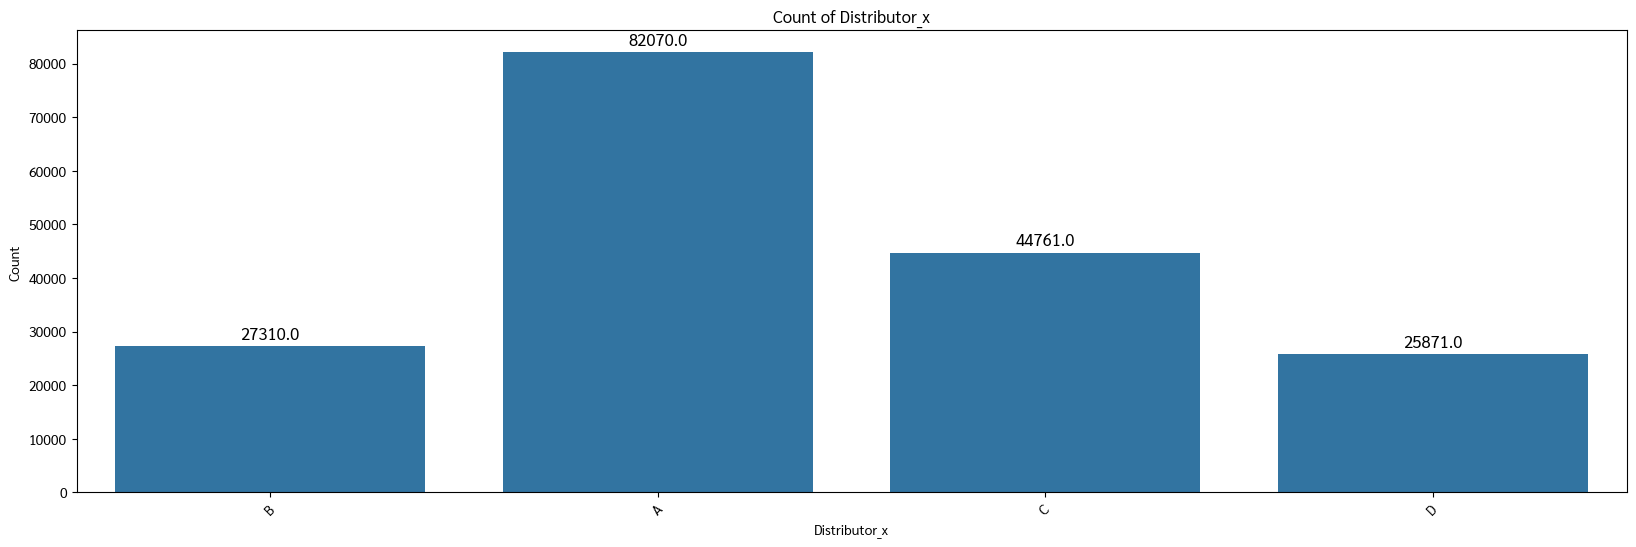

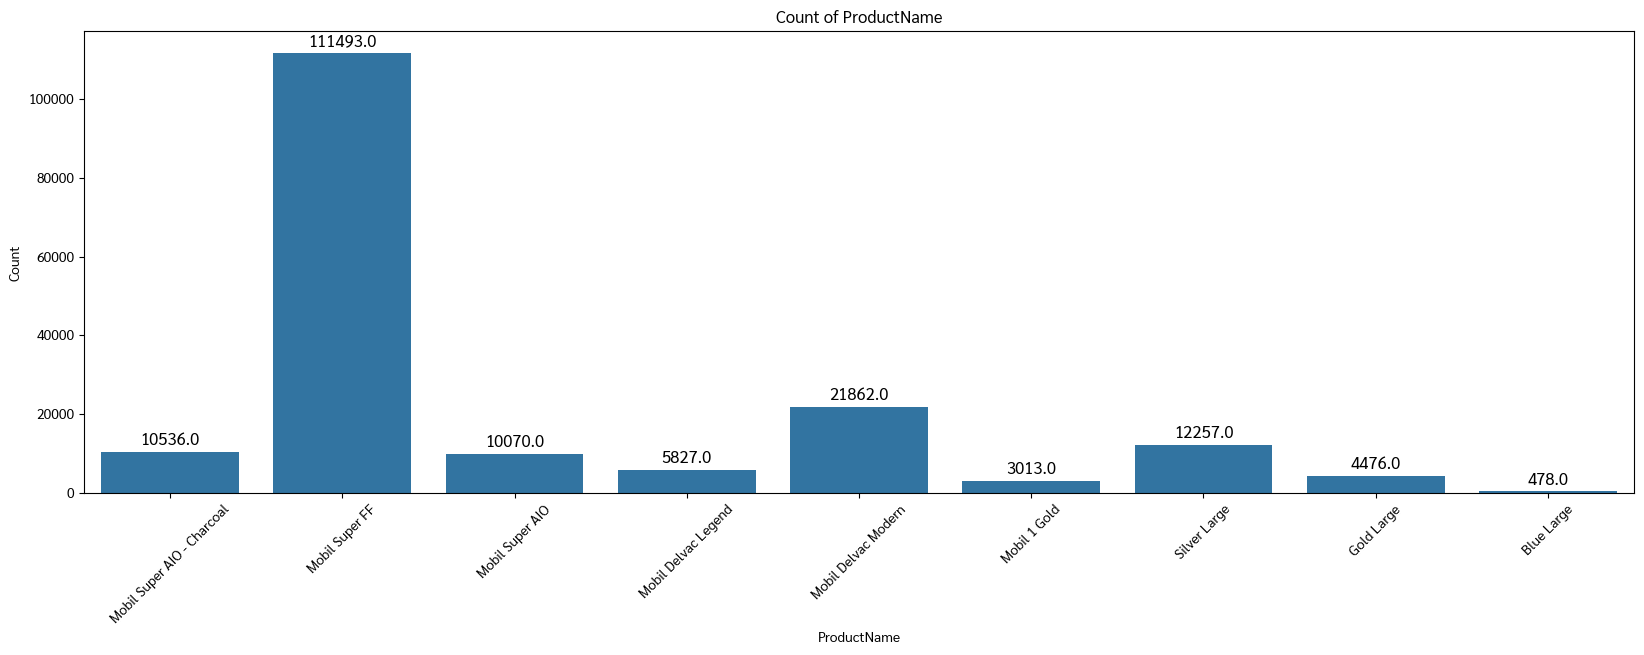

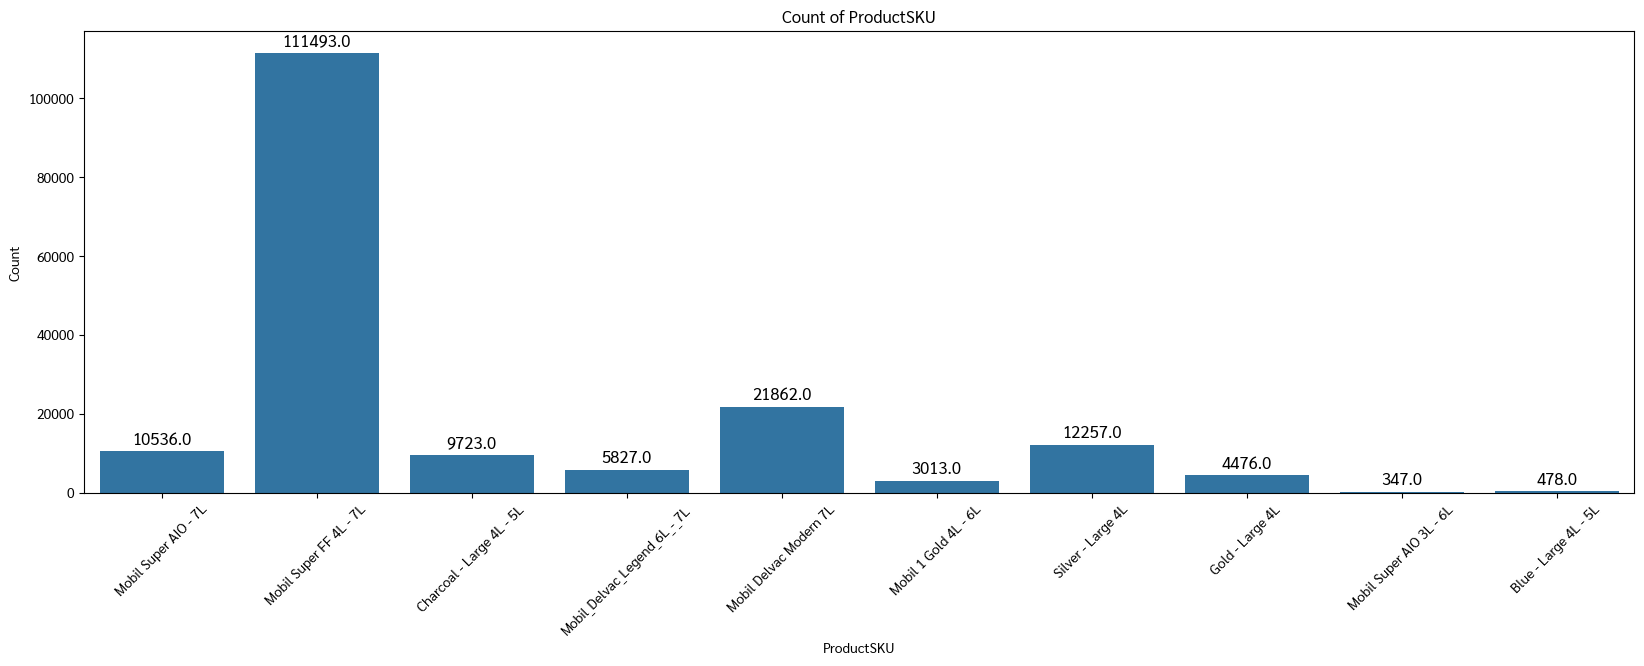

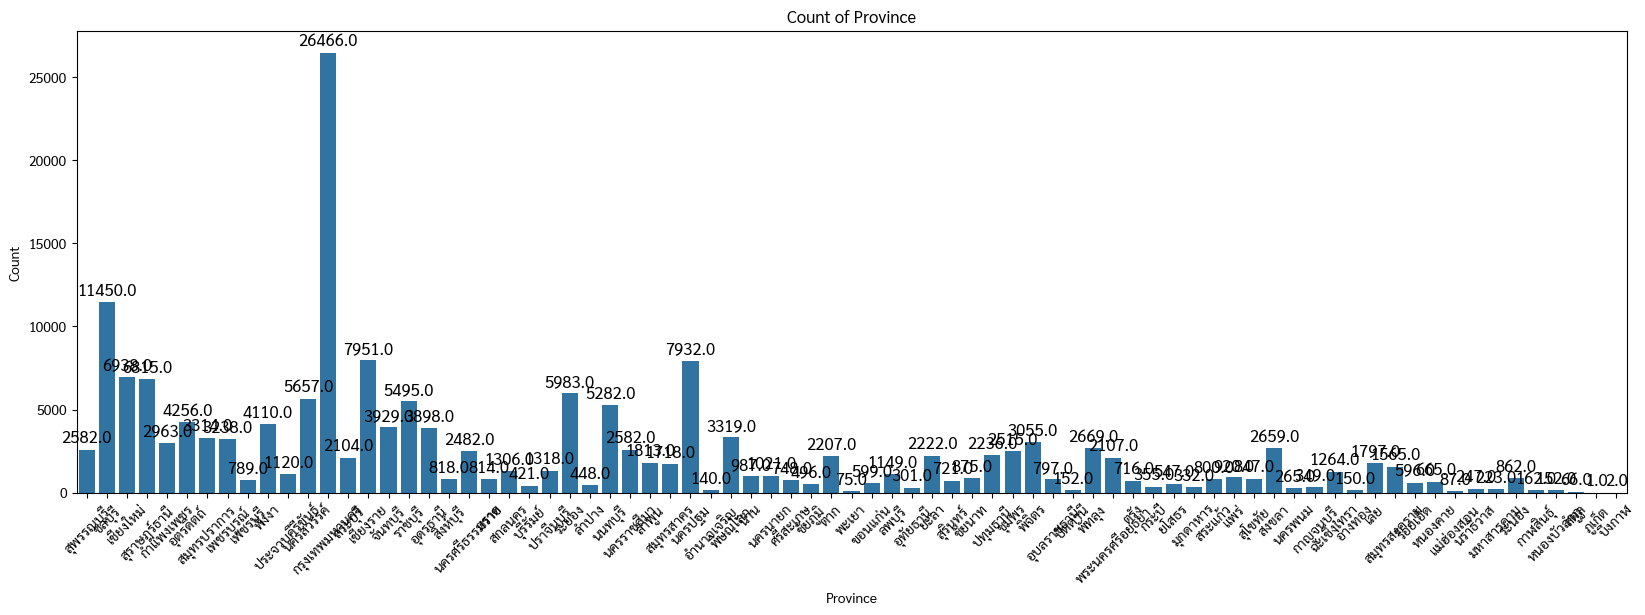

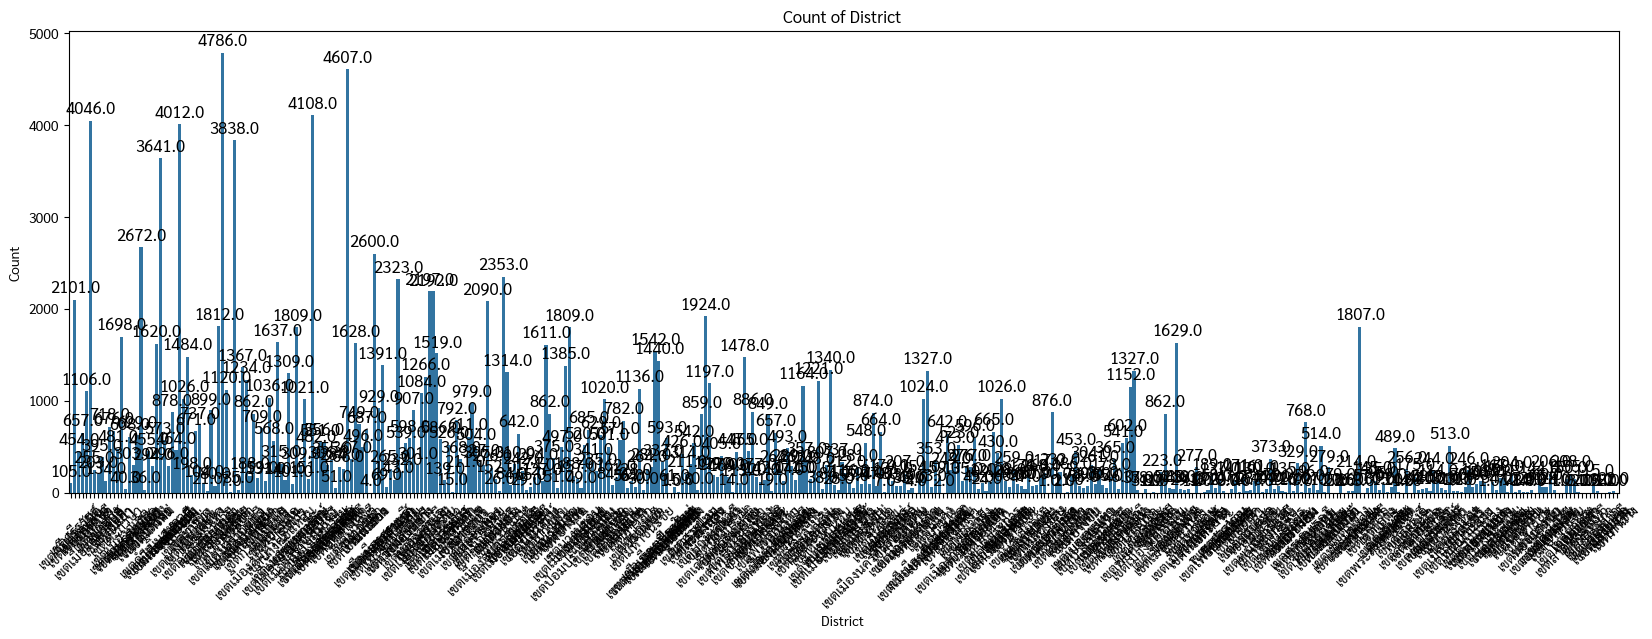

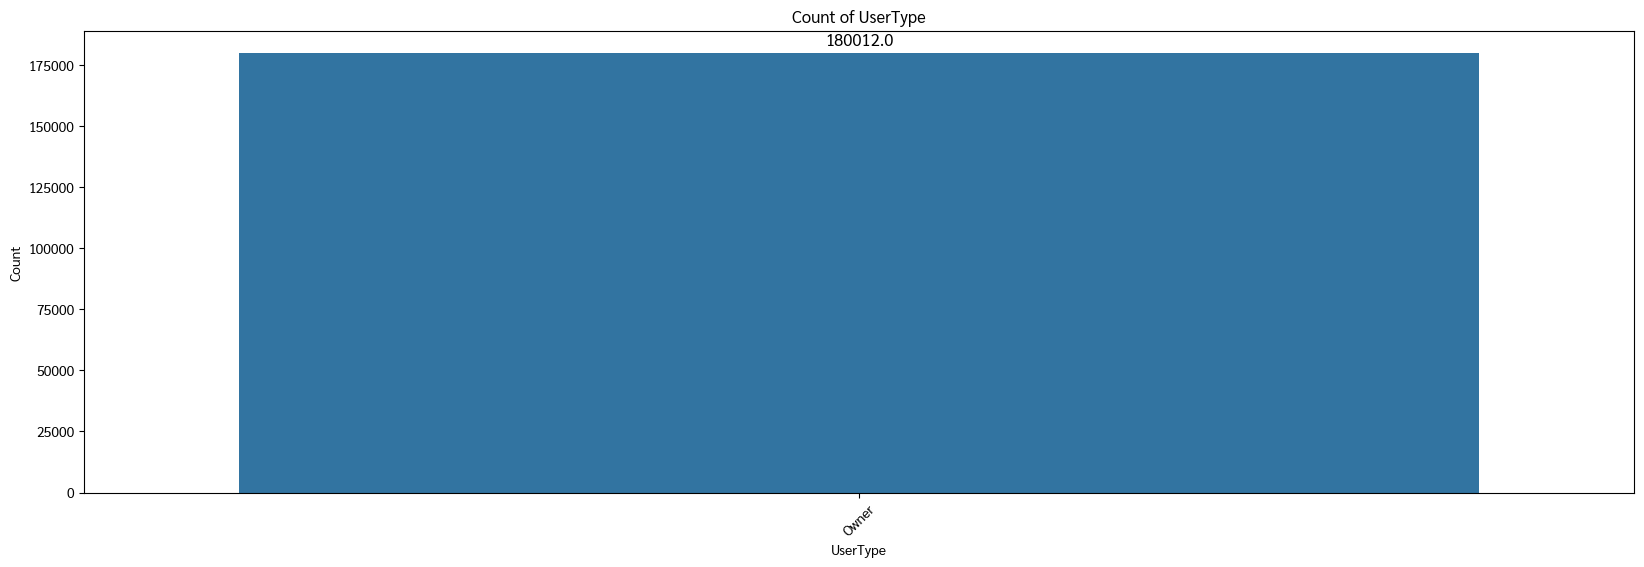

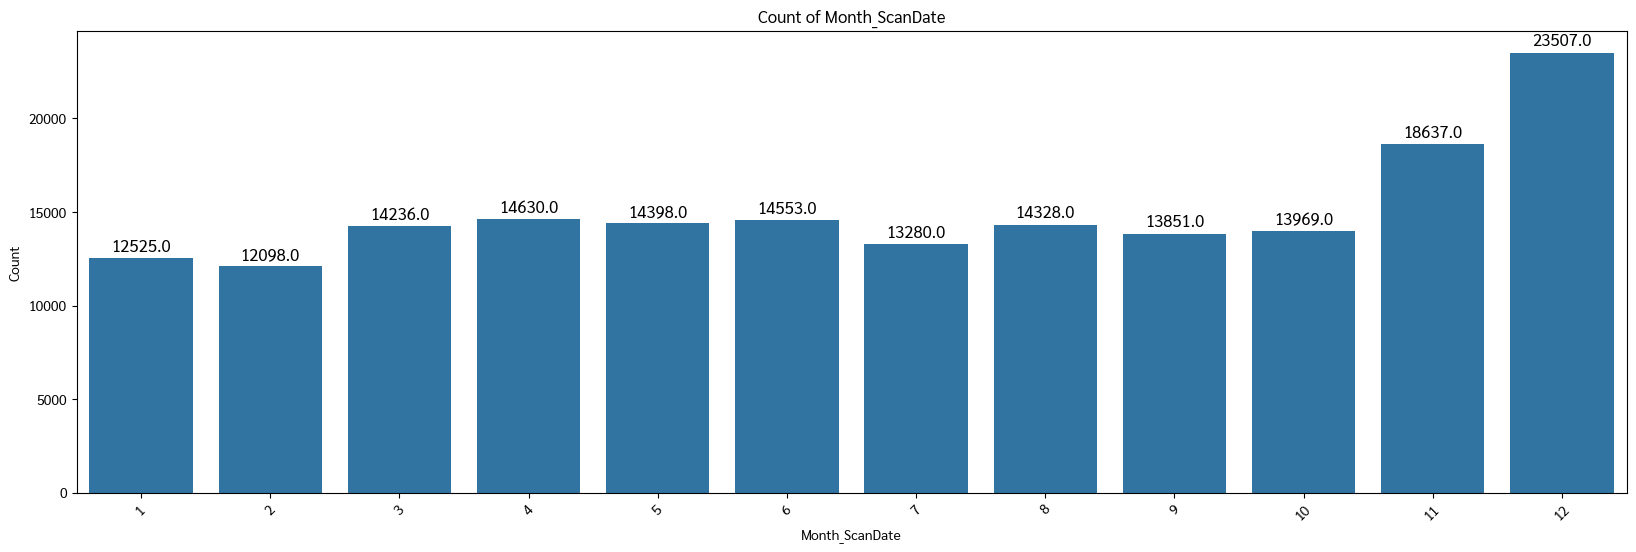

In [ ]:
for column in MRW_qualitative:
    plt.figure(figsize=(20, 6))
    ax = sns.countplot(data=mrw_df, x=column)
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    # Add count labels on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.xticks(rotation=45)
    plt.show()

Text(0.5, 1.0, 'Features Correlation')

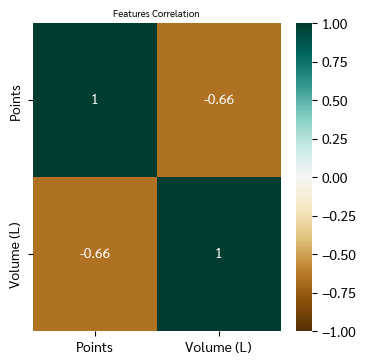

In [ ]:
spearman_corr = mrw_df[MRW_quantitative].corr(method='spearman')

plt.figure(figsize=(4, 4))
heatmap = sns.heatmap(mrw_df[MRW_quantitative].corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlation', fontdict={'fontsize':7}, pad=5)

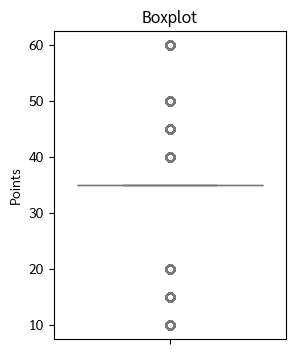

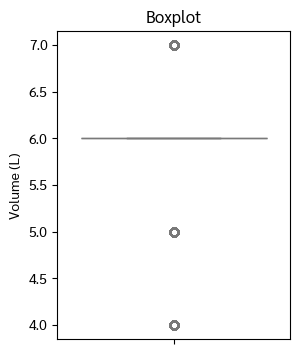

In [ ]:
for col in MRW_quantitative:
  plt.figure(figsize=(3, 4))
  sns.boxplot(y=col, data=mrw_df, color = "palegreen")
  plt.ylabel(col)
  plt.title('Boxplot')
  plt.show()

# EDA

<Axes: xlabel='Distributor_x'>

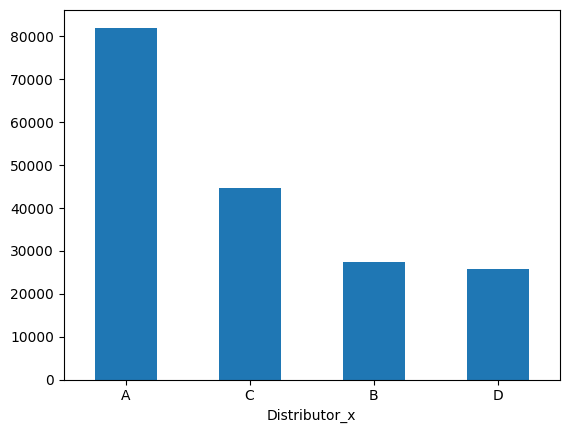

In [ ]:
mrw_df['Distributor_x'].value_counts().plot.bar(rot=0)

In [ ]:
mrw_df['ProductSKU'].unique()

array(['Mobil Super AIO - 7L', 'Mobil Super FF 4L - 7L',
       'Charcoal - Large 4L - 5L', 'Mobil_Delvac_Legend_6L_-_7L',
       'Mobil Delvac Modern 7L', 'Mobil 1 Gold 4L - 6L',
       'Silver - Large 4L', 'Gold - Large 4L', 'Mobil Super AIO 3L - 6L',
       'Blue - Large 4L - 5L'], dtype=object)

<Axes: xlabel='ProductSKU'>

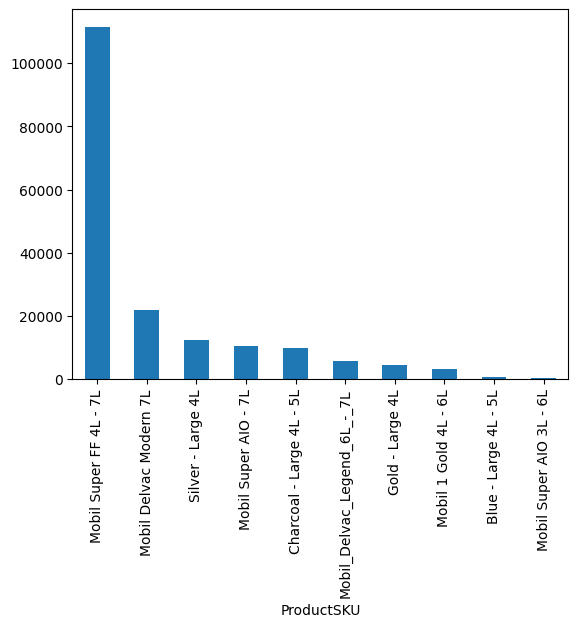

In [ ]:
mrw_df['ProductSKU'].value_counts().plot.bar()

In [ ]:
mrw_df['UserId'].value_counts()

UserId
EXL_1616574618013    2519
EXL_1691757071956    2329
EXL_1672402052826    2113
EXL_1570180752677    2062
EXL_1580465142891    1900
                     ... 
EXL_1617722535396       1
EXL_1573734024715       1
EXL_1581423429266       1
EXL_1682602835007       1
EXL_1683459735507       1
Name: count, Length: 1272, dtype: int64

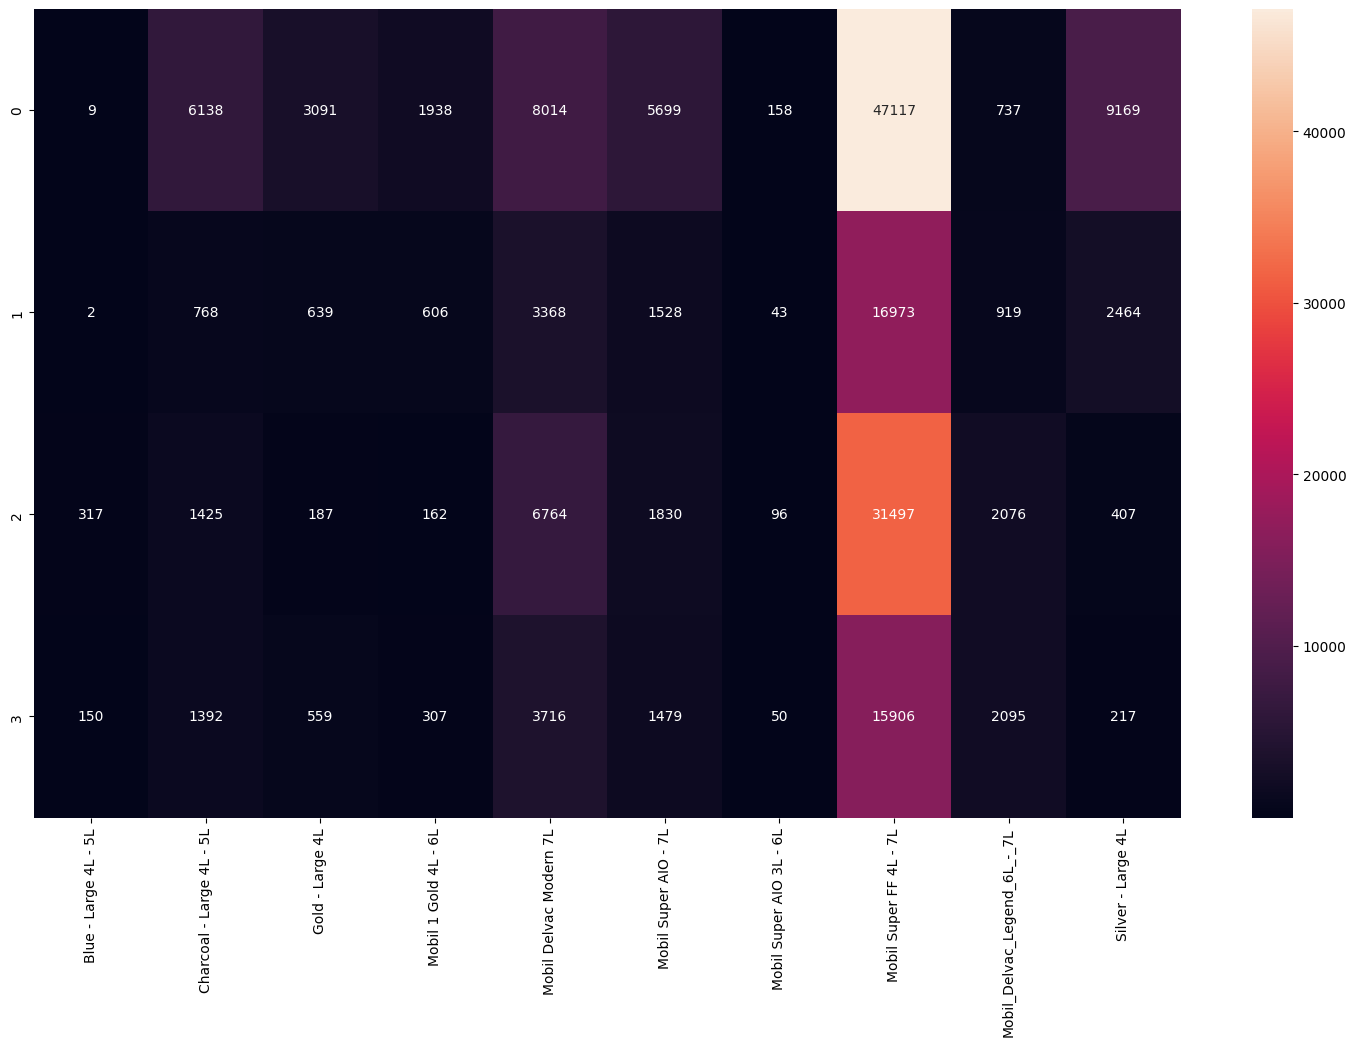

In [ ]:
tmp_count_sku_per_distributor_df = []
for dist in ['A','B','C','D']:
  # print(dist)
  tmp_count_sku_per_distributor_df.append(mrw_df[mrw_df['Distributor_y']==dist]['ProductSKU'].value_counts().sort_index(key=lambda x : x.str.lower()).to_dict())
  plt.show()

sns.heatmap(pd.DataFrame(tmp_count_sku_per_distributor_df), annot=True,fmt='.0f')

# fig set imaeg to be bigger
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

## split by province

In [ ]:
response = requests.get("https://raw.githubusercontent.com/rathpanyowat/Thai-zip-code-latitude-and-longitude/master/data.json")
data = json.loads(response.text)

# map province location
map_loc = {}
for e in data:
  map_loc[e['zip']] = (e['lat'],e['lng'])

In [ ]:
# โหลดไฟล์ GeoJSON ของประเทศไทย
url = 'https://raw.githubusercontent.com/apisit/thailand.json/master/thailand.json'
response = requests.get(url)
thailand_geojson = response.json()

In [ ]:
province_name_mapping = {
    'กรุงเทพมหานคร': 'Bangkok Metropolis',
    'กระบี่': 'Krabi',
    'กาญจนบุรี': 'Kanchanaburi',
    'กาฬสินธุ์': 'Kalasin',
    'กำแพงเพชร': 'Kamphaeng Phet',
    'ขอนแก่น': 'Khon Kaen',
    'จันทบุรี': 'Chanthaburi',
    'ฉะเชิงเทรา': 'Chachoengsao',
    'ชลบุรี': 'Chon Buri',
    'ชัยนาท': 'Chai Nat',
    'ชัยภูมิ': 'Chaiyaphum',
    'ชุมพร': 'Chumphon',
    'เชียงราย': 'Chiang Rai',
    'เชียงใหม่': 'Chiang Mai',
    'ตรัง': 'Trang',
    'ตราด': 'Trat',
    'ตาก': 'Tak',
    'นครนายก': 'Nakhon Nayok',
    'นครปฐม': 'Nakhon Pathom',
    'นครพนม': 'Nakhon Phanom',
    'นครราชสีมา': 'Nakhon Ratchasima',
    'นครศรีธรรมราช': 'Nakhon Si Thammarat',
    'นครสวรรค์': 'Nakhon Sawan',
    'นนทบุรี': 'Nonthaburi',
    'นราธิวาส': 'Narathiwat',
    'น่าน': 'Nan',
    'บึงกาฬ': 'Bueng Kan',
    'บุรีรัมย์': 'Buri Ram',
    'ปทุมธานี': 'Pathum Thani',
    'ประจวบคีรีขันธ์': 'Prachuap Khiri Khan',
    'ปราจีนบุรี': 'Prachin Buri',
    'ปัตตานี': 'Pattani',
    'พระนครศรีอยุธยา': 'Phra Nakhon Si Ayutthaya',
    'พะเยา': 'Phayao',
    'พังงา': 'Phangnga',
    'พัทลุง': 'Phatthalung',
    'พิจิตร': 'Phichit',
    'พิษณุโลก': 'Phitsanulok',
    'เพชรบุรี': 'Phetchaburi',
    'เพชรบูรณ์': 'Phetchabun',
    'แพร่': 'Phrae',
    'ภูเก็ต': 'Phuket',
    'มหาสารคาม': 'Maha Sarakham',
    'มุกดาหาร': 'Mukdahan',
    'แม่ฮ่องสอน': 'Mae Hong Son',
    'ยโสธร': 'Yasothon',
    'ยะลา': 'Yala',
    'ร้อยเอ็ด': 'Roi Et',
    'ระนอง': 'Ranong',
    'ระยอง': 'Rayong',
    'ราชบุรี': 'Ratchaburi',
    'ลพบุรี': 'Lop Buri',
    'ลำปาง': 'Lampang',
    'ลำพูน': 'Lamphun',
    'เลย': 'Loei',
    'ศรีสะเกษ': 'Si Sa Ket',
    'สกลนคร': 'Sakon Nakhon',
    'สงขลา': 'Songkhla',
    'สตูล': 'Satun',
    'สมุทรปราการ': 'Samut Prakan',
    'สมุทรสงคราม': 'Samut Songkhram',
    'สมุทรสาคร': 'Samut Sakhon',
    'สระแก้ว': 'Sa Kaeo',
    'สระบุรี': 'Saraburi',
    'สิงห์บุรี': 'Sing Buri',
    'สุโขทัย': 'Sukhothai',
    'สุพรรณบุรี': 'Suphan Buri',
    'สุราษฎร์ธานี': 'Surat Thani',
    'สุรินทร์': 'Surin',
    'หนองคาย': 'Nong Khai',
    'หนองบัวลำภู': 'Nong Bua Lam Phu',
    'อ่างทอง': 'Ang Thong',
    'อำนาจเจริญ': 'Amnat Charoen',
    'อุดรธานี': 'Udon Thani',
    'อุตรดิตถ์': 'Uttaradit',
    'อุทัยธานี': 'Uthai Thani',
    'อุบลราชธานี': 'Ubon Ratchathani'
  }

<Axes: xlabel='Province_en'>

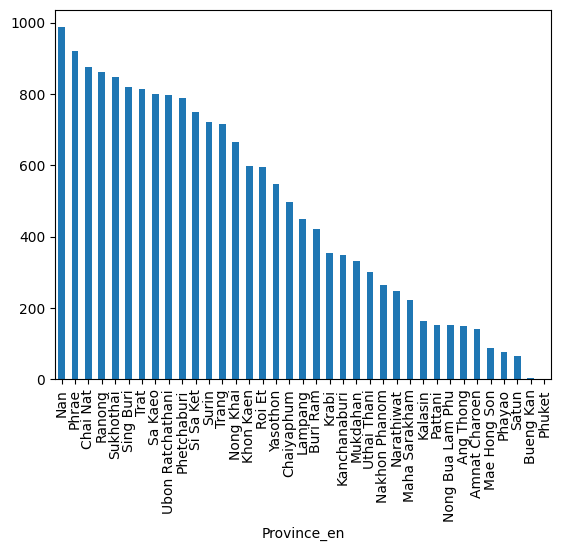

In [ ]:
mrw_df['Province_en'] = mrw_df['Province'].apply(lambda x : province_name_mapping[x])
mrw_df['Province_en'].value_counts()[(mrw_df['Province_en'].value_counts()<1000)].plot.bar()

In [ ]:
def plot_province(name,df):

  # สร้าง GeoDataFrame จาก GeoJSON
  thailand_gdf = gpd.GeoDataFrame.from_features(thailand_geojson["features"])

  # เตรียมข้อมูลการนับจำนวนธุรกรรมในแต่ละจังหวัด
  province_counts = df['Province_en'].value_counts().reset_index()
  province_counts.columns = ['Province_en', 'Count']


  # รวมข้อมูล GeoDataFrame กับข้อมูลการนับจำนวนธุรกรรม
  thailand_gdf = thailand_gdf.merge(province_counts, left_on='name', right_on='Province_en', how='left')

  # การแสดงผลแผนที่
  fig, ax = plt.subplots(1, 1, figsize=(15, 15))
  thailand_gdf.boundary.plot(ax=ax)
  thailand_gdf.plot(column='Count', ax=ax, legend=True, cmap='OrRd', missing_kwds={"color": "lightgrey"})

  plt.title(name)
  plt.show()


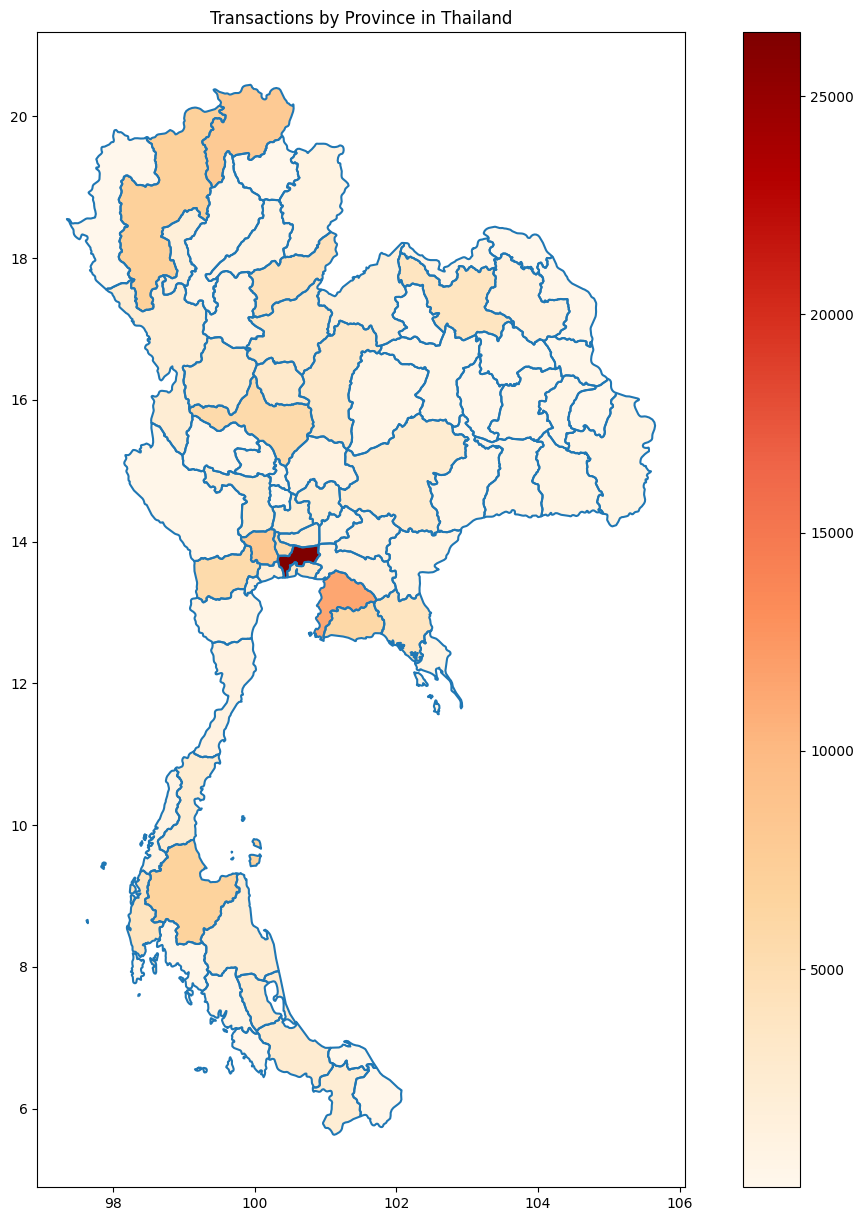

In [ ]:
plot_province('Transactions by Province in Thailand',mrw_df)

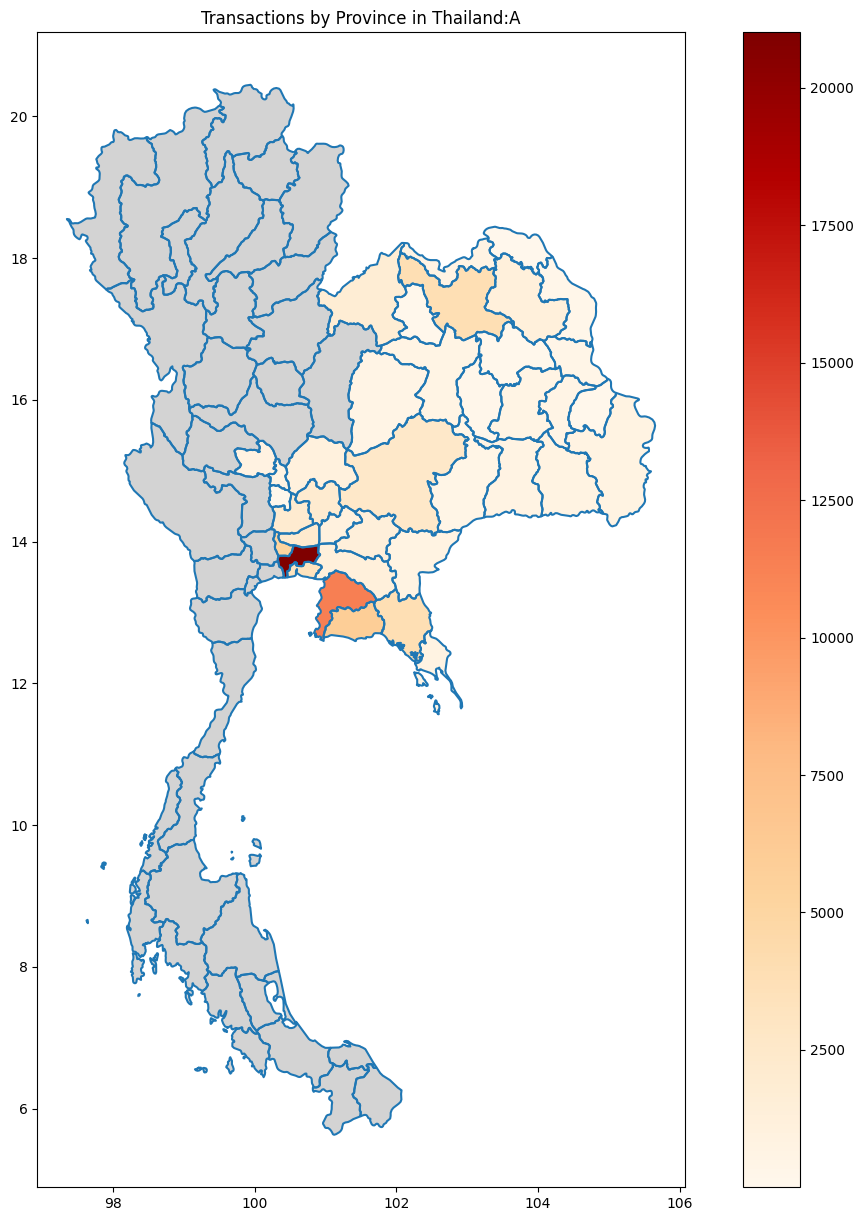

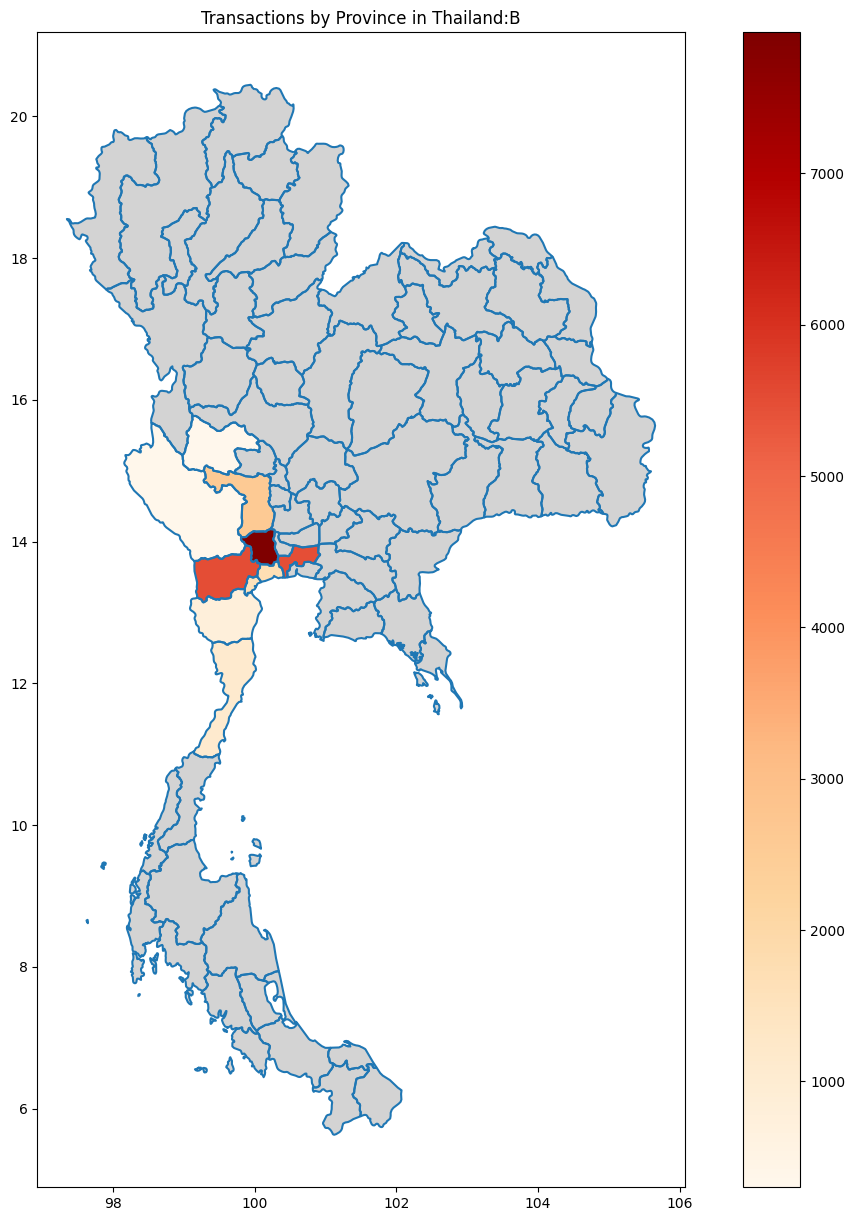

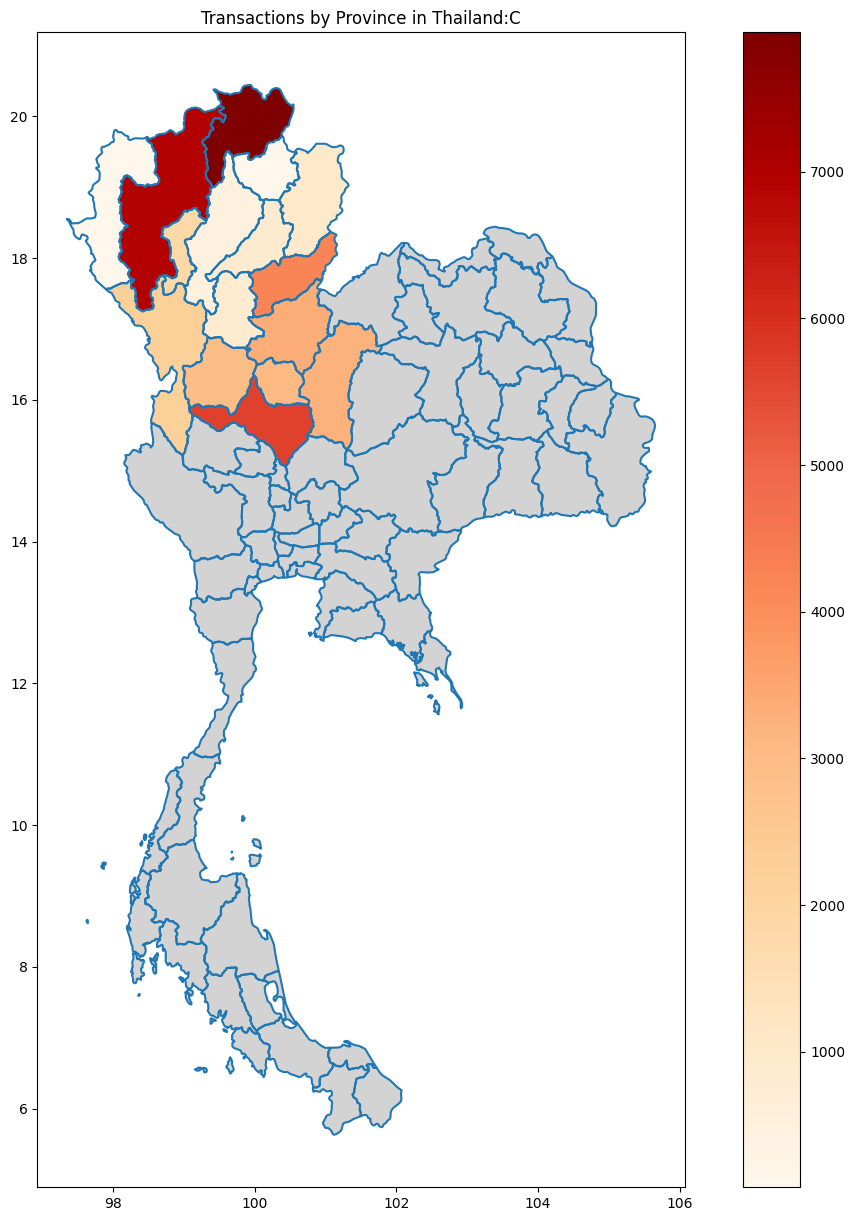

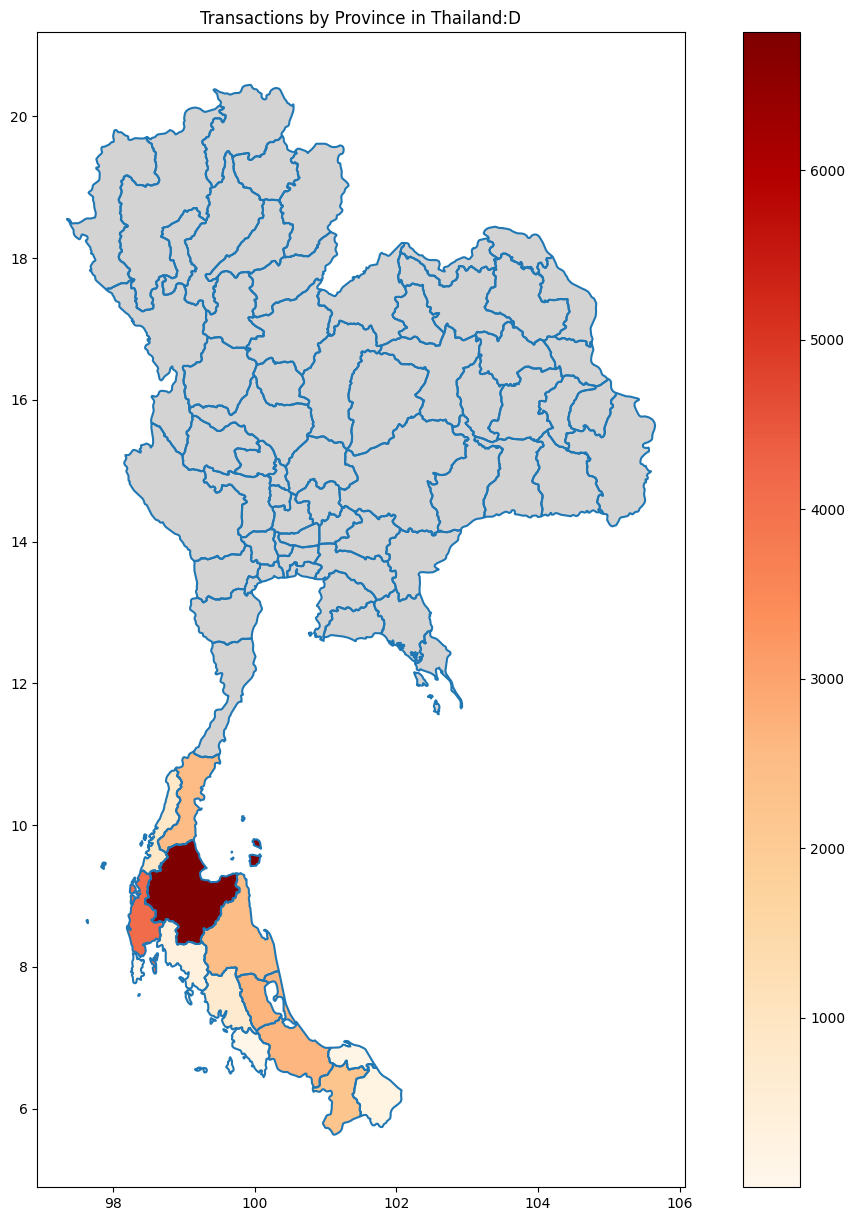

In [ ]:
for dist in ['A','B','C','D']:
  plot_province('Transactions by Province in Thailand:'+dist,mrw_df[mrw_df['Distributor_x']==dist])

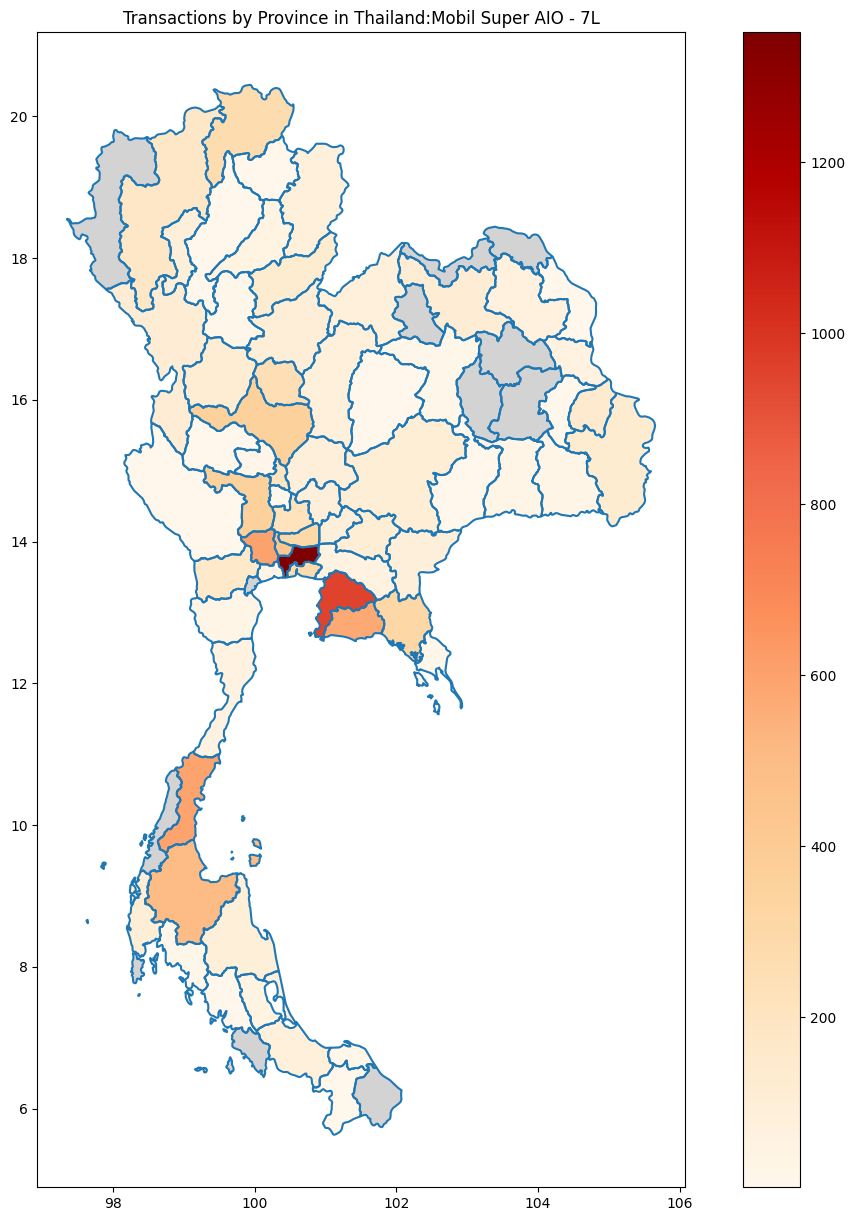

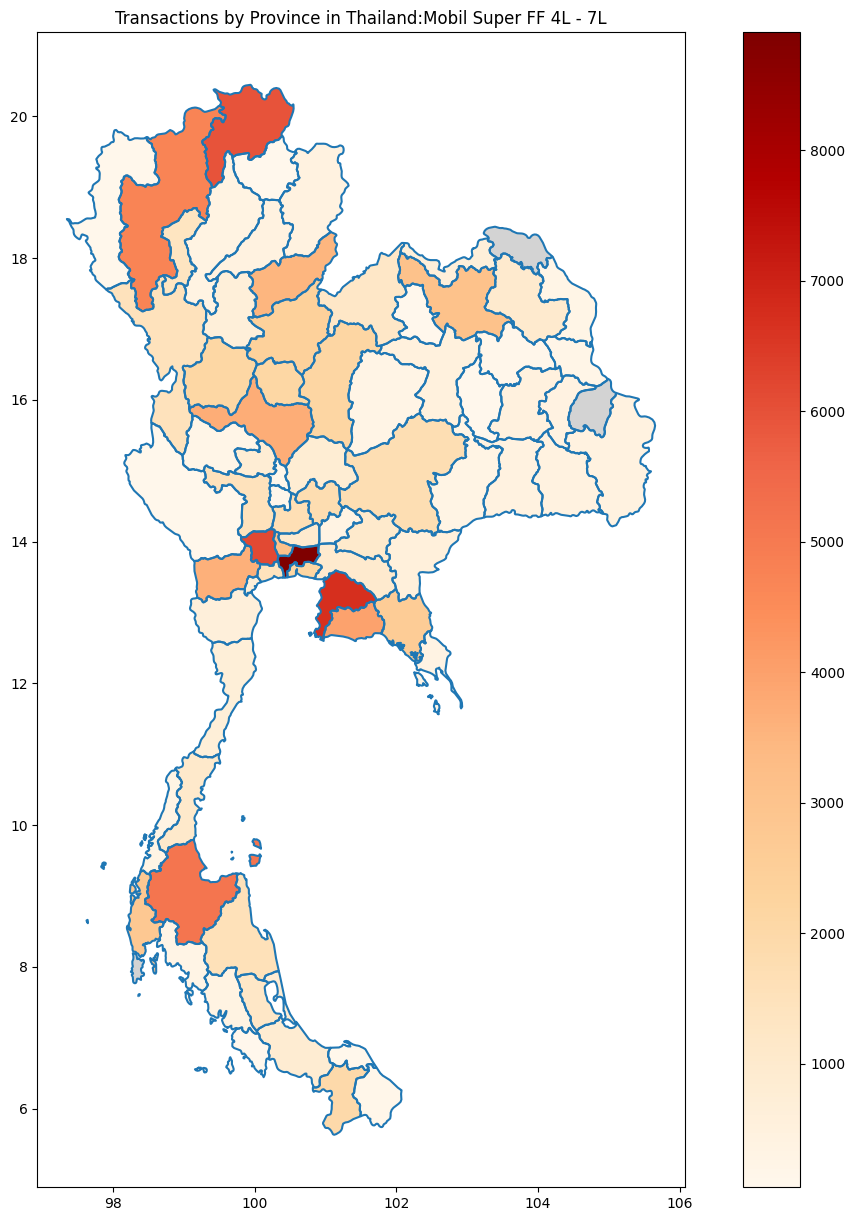

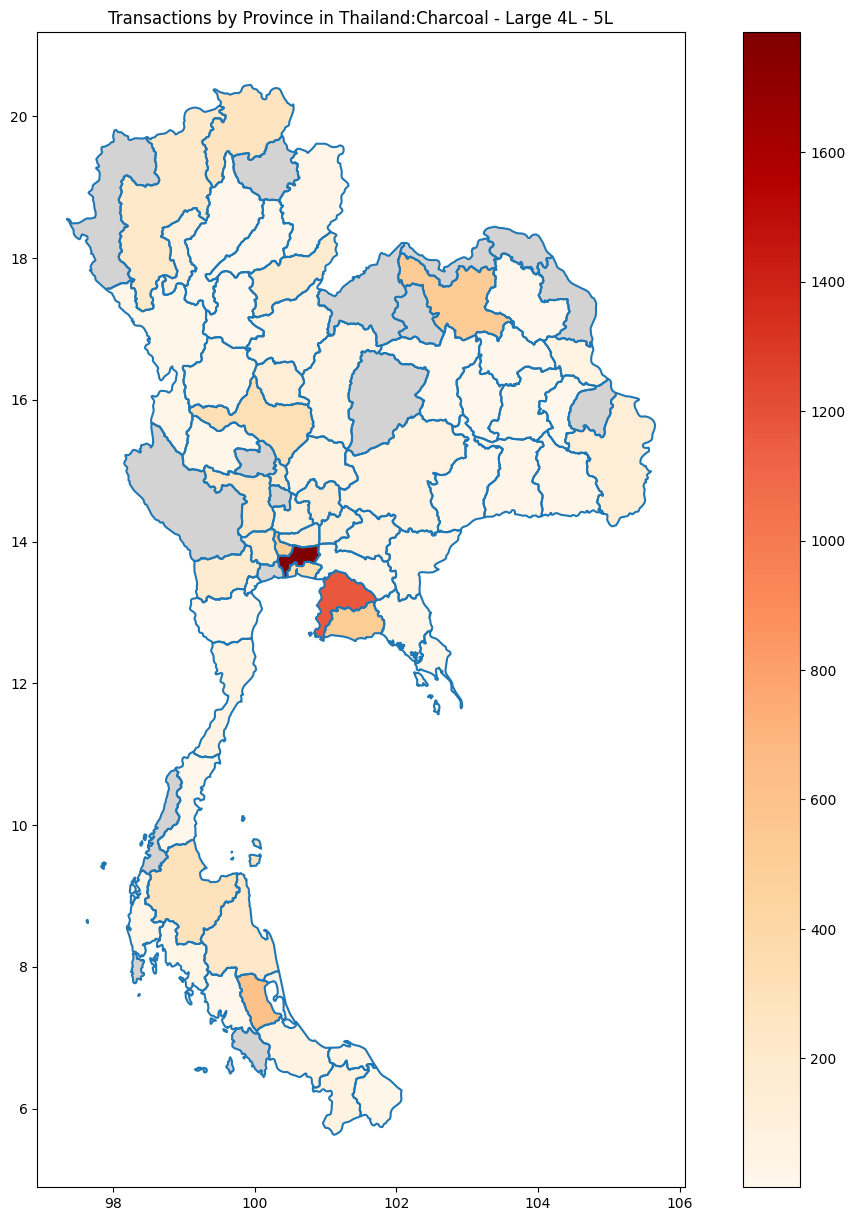

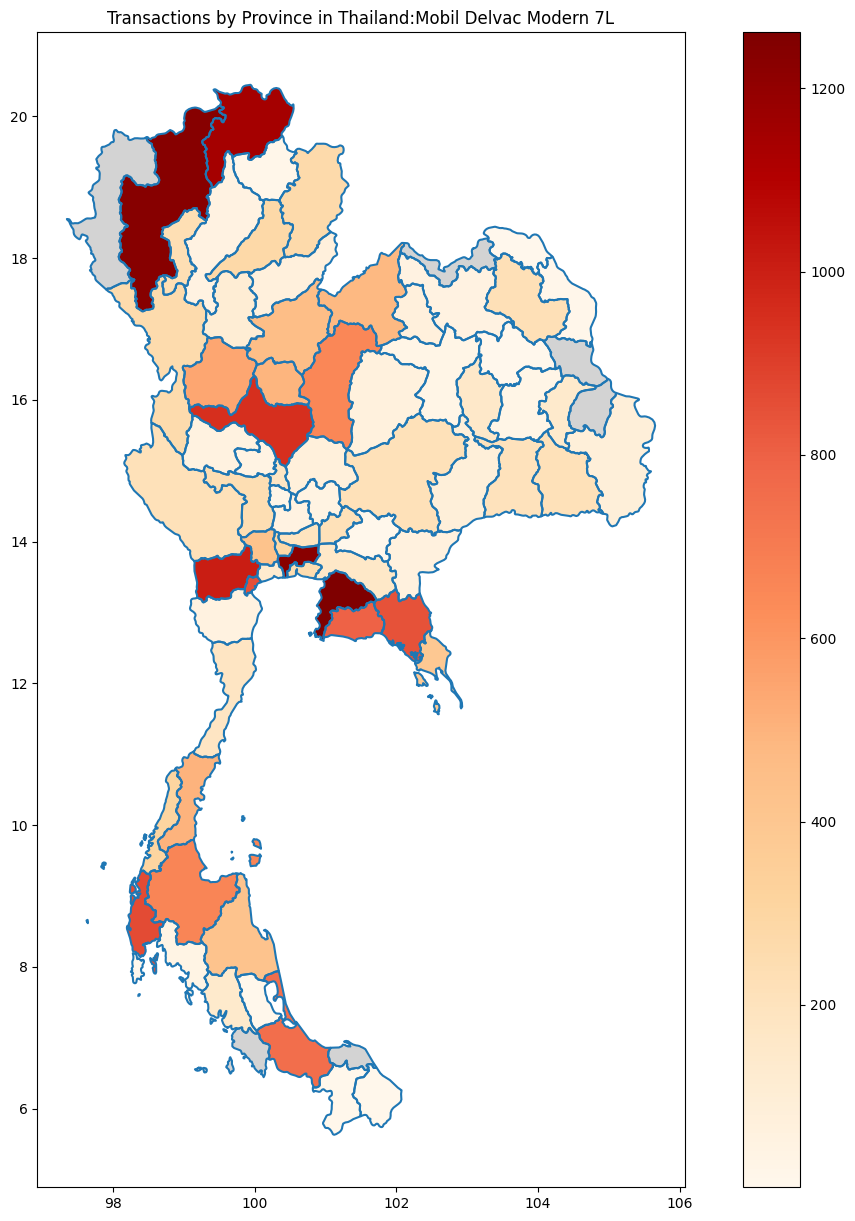

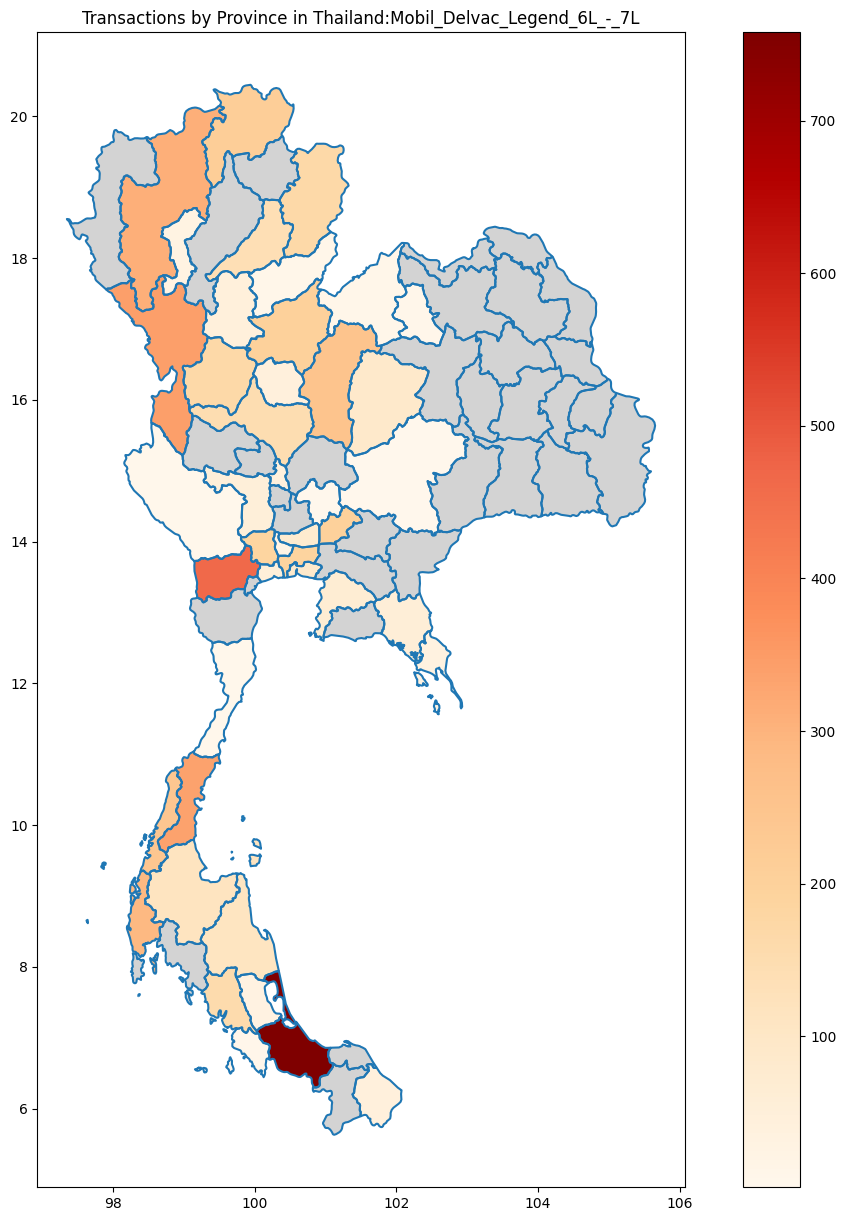

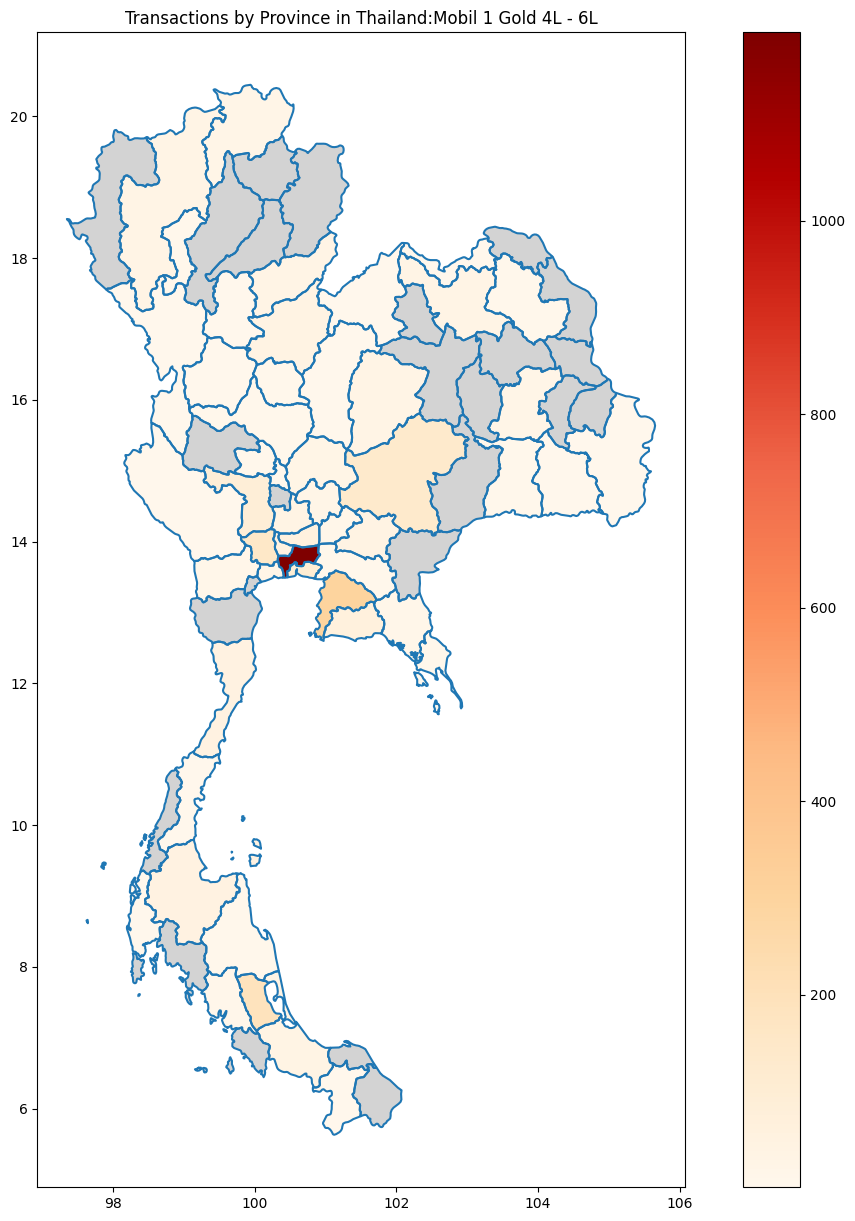

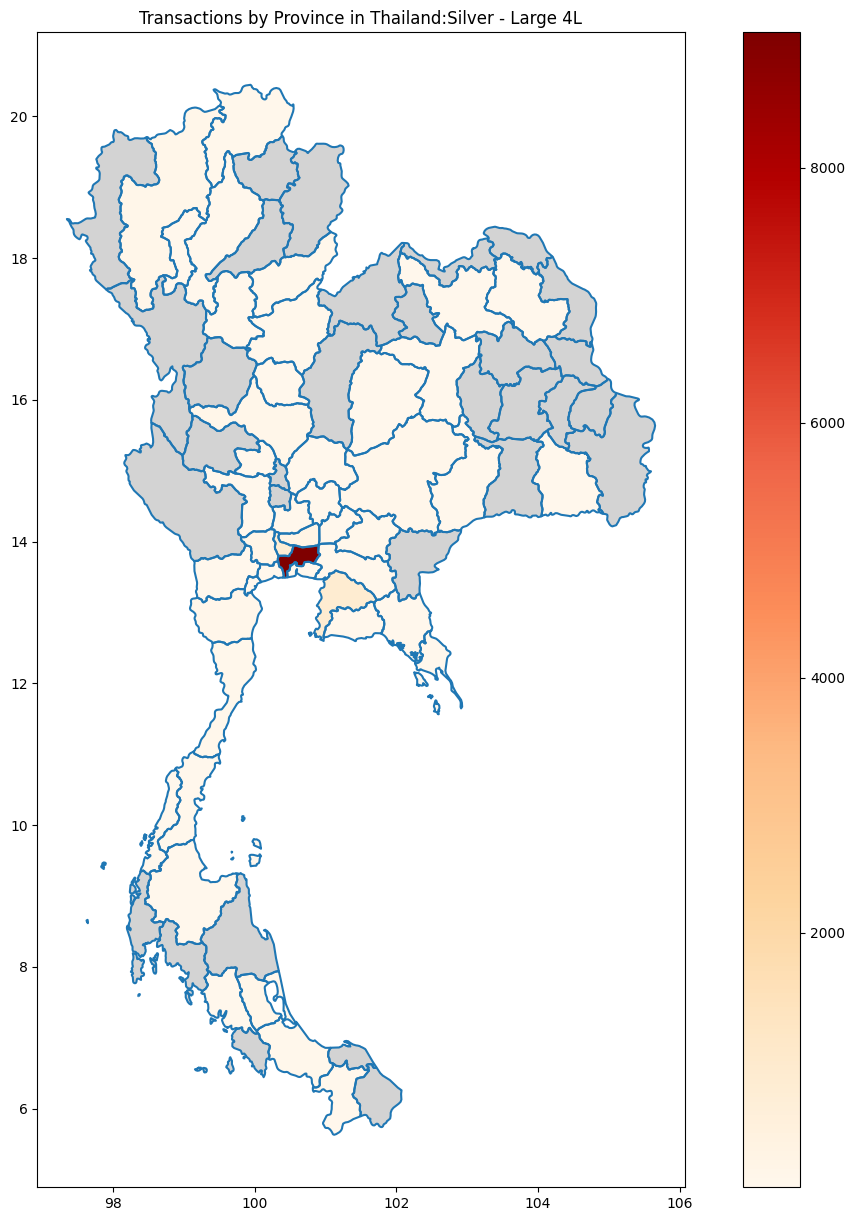

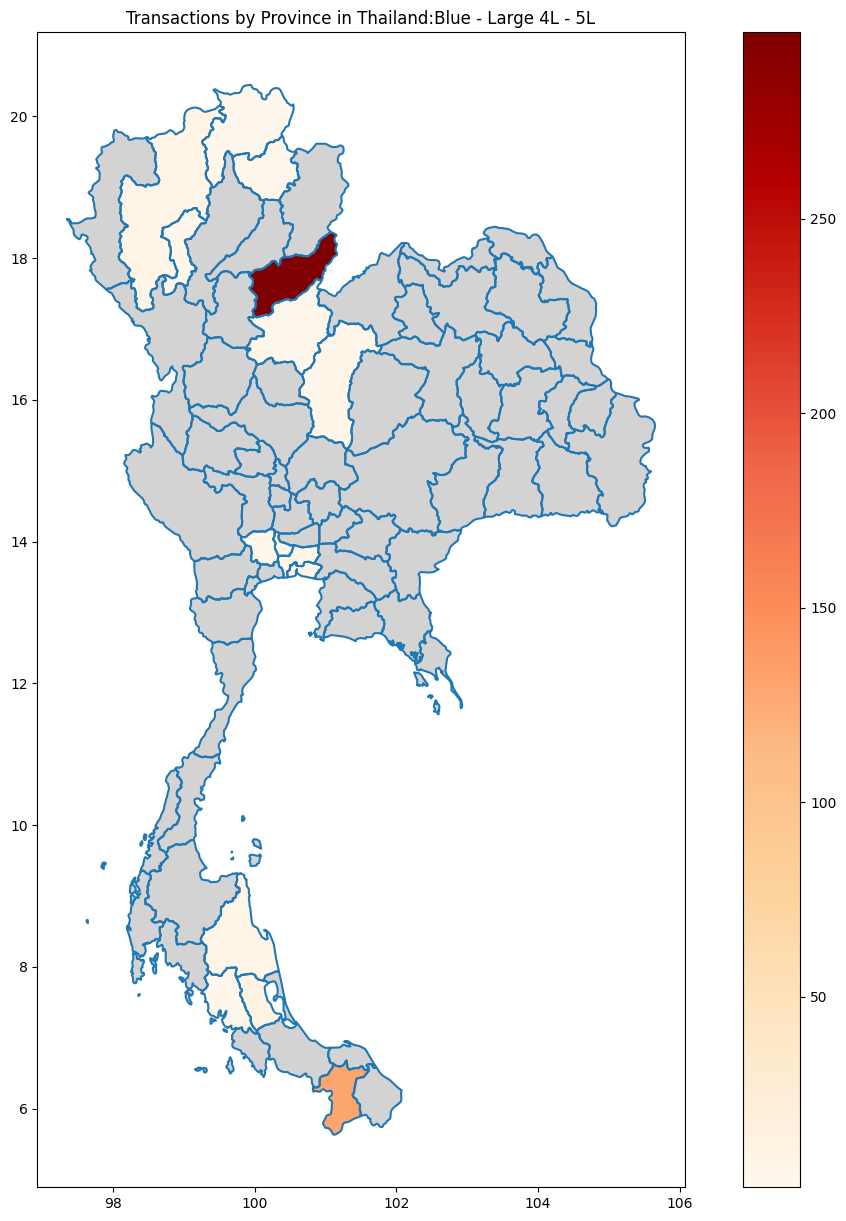

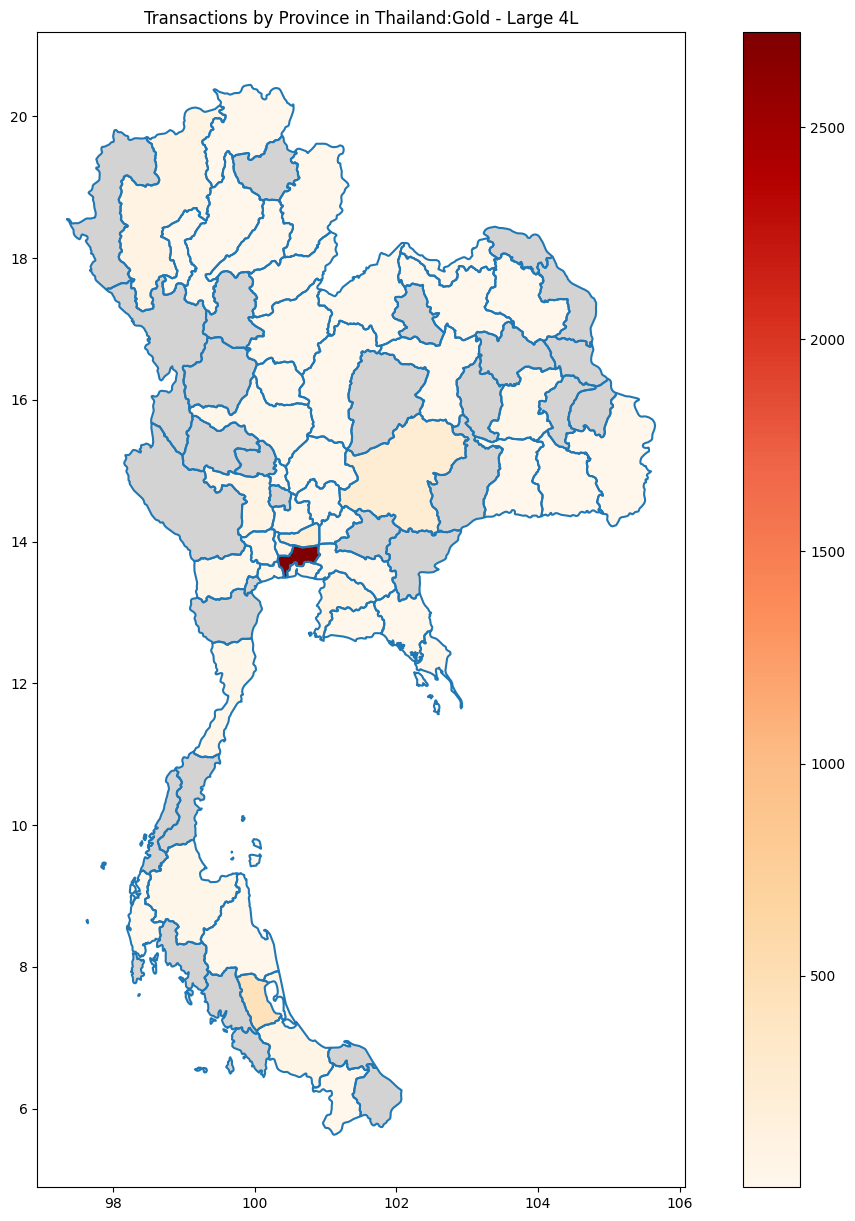

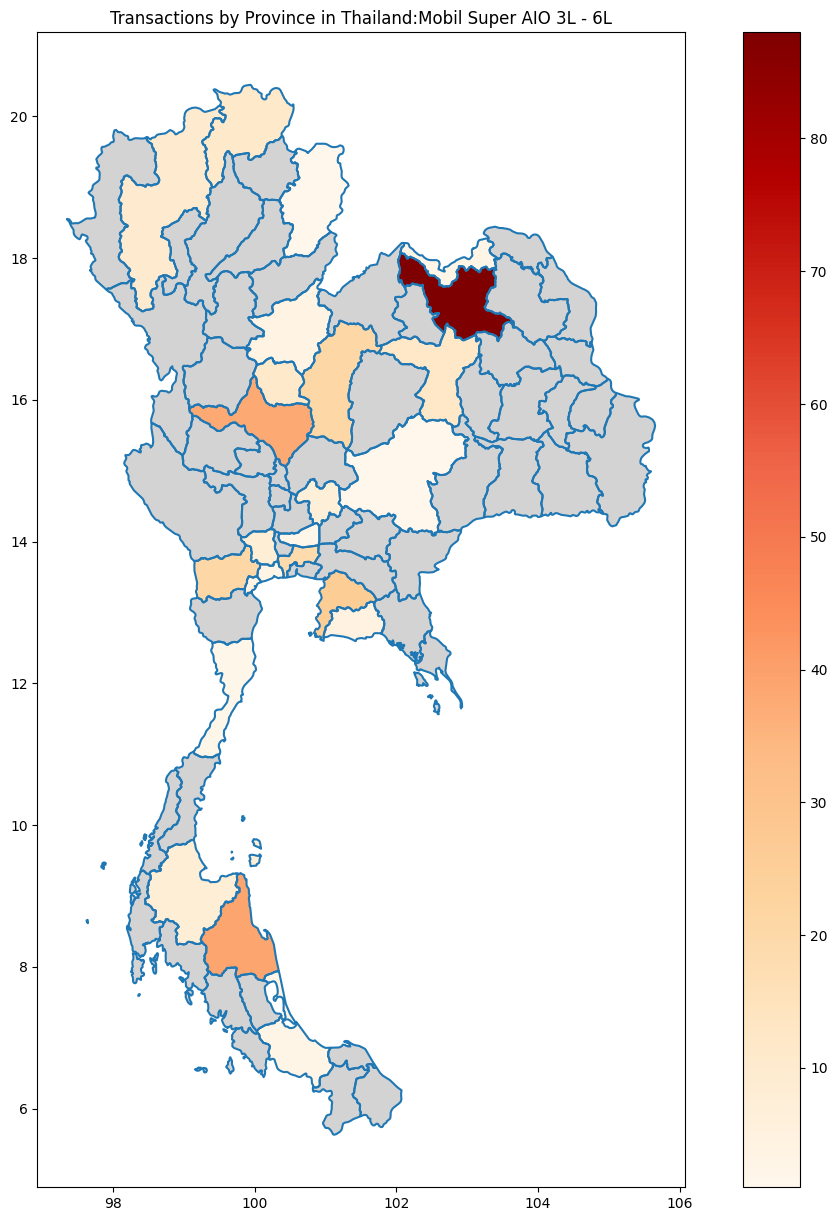

In [ ]:
product_list = ['Mobil Super AIO - 7L', 'Mobil Super FF 4L - 7L',
       'Charcoal - Large 4L - 5L', 'Mobil Delvac Modern 7L',
       'Mobil_Delvac_Legend_6L_-_7L', 'Mobil 1 Gold 4L - 6L',
       'Silver - Large 4L', 'Blue - Large 4L - 5L', 'Gold - Large 4L',
       'Mobil Super AIO 3L - 6L']


for product in product_list:
  # print(product)
  plot_province('Transactions by Province in Thailand:'+product,mrw_df[mrw_df['ProductSKU']==product])

## RF analysis

In [ ]:

# Convert ScanDate to datetime format
mrw_df['ScanDate'] = pd.to_datetime(mrw_df['ScanDate'])

# Calculate the frequency (number of visits) for each user
frequency = mrw_df.groupby('OwnerId').size().reset_index(name='Frequency')

# Calculate the retention (time since last visit) for each user
current_date = mrw_df['ScanDate'].max()
last_visit = mrw_df.groupby('OwnerId')['ScanDate'].max().reset_index()
last_visit['Retention'] = (current_date - last_visit['ScanDate']).dt.days

# Merge frequency and retention mrw_df
rf_mrw_df = pd.merge(frequency, last_visit[['OwnerId', 'Retention']], on='OwnerId')

# Create bins for frequency and retention
frequency_bins = pd.qcut(rf_mrw_df['Frequency'], 5, labels=False) + 1
retention_bins = pd.qcut(rf_mrw_df['Retention'], 5, labels=False) + 1

# Add bins to the mrw_dfframe
rf_mrw_df['FrequencyBin'] = frequency_bins
rf_mrw_df['RetentionBin'] = retention_bins

# Create the RF matrix
rf_matrix = rf_mrw_df.groupby(['FrequencyBin', 'RetentionBin']).size().unstack(fill_value=0)

# Display the RF matrix
print(rf_matrix)

RetentionBin   1   2   3   4    5
FrequencyBin                     
1             12  16  35  58  141
2             32  38  57  64   61
3             60  71  45  52   27
4             69  66  48  44   22
5             86  75  57  32    4


In [ ]:
rf_mrw_df.to_csv("rf_data.csv")

In [ ]:
rf_df = pd.read_csv("rf_data.csv")
rf_df.head(2)

Unnamed: 0            OwnerId  Frequency  Retention  FrequencyBin  \
0           0  EXL_1569867483497          7         29             1   
1           1  EXL_1569928027697        189          5             4   

   RetentionBin  
0             3  
1             1

<Axes: >

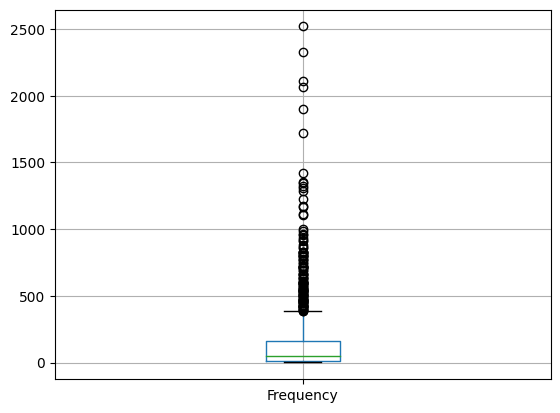

In [ ]:
rf_mrw_df.boxplot(column=['Frequency'])

<Axes: >

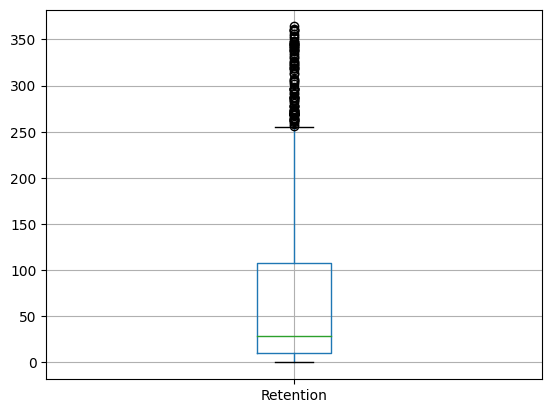

In [ ]:
rf_mrw_df.boxplot(column=[ 'Retention'])

### explain

Retention
- r น้อย คือเข้ามาล่าสุดเร็ว
- r มาก คือ ไม่ได้มาซื้อนานแล้ว
```
[(-0.001, 6.0] < (6.0, 19.0] < (19.0, 44.0] <
(44.0, 147.8] < (147.8, 364.0]]
```

Frequency
- f น้อย คือ นานๆซื้อที
- f มาก คือ ซื้อบ่อยมาก
```
[(0.999, 9.0] < (9.0, 32.0] < (32.0, 80.0] <
(80.0, 205.0] < (205.0, 2519.0]]
```



In [ ]:
rf_mrw_df['RetentionBin'].value_counts()

RetentionBin
2    266
1    259
5    255
4    250
3    242
Name: count, dtype: int64

In [ ]:
rf_mrw_df['FrequencyBin'].value_counts()

FrequencyBin
1    262
3    255
5    254
2    252
4    249
Name: count, dtype: int64

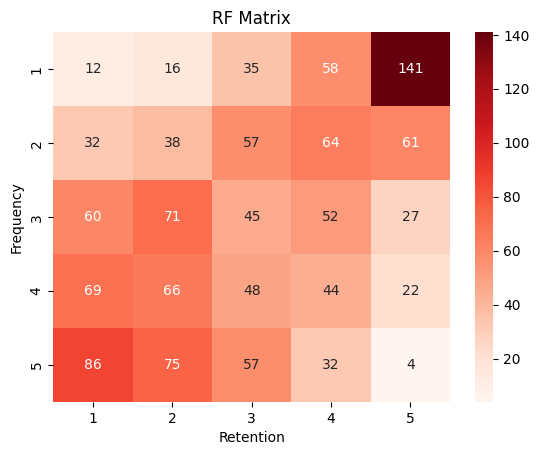

In [ ]:
# Create the heatmap
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap="Reds")

# Add labels and title
plt.xlabel("Retention")
plt.ylabel("Frequency")
plt.title("RF Matrix")

# Show the heatmap
plt.show()

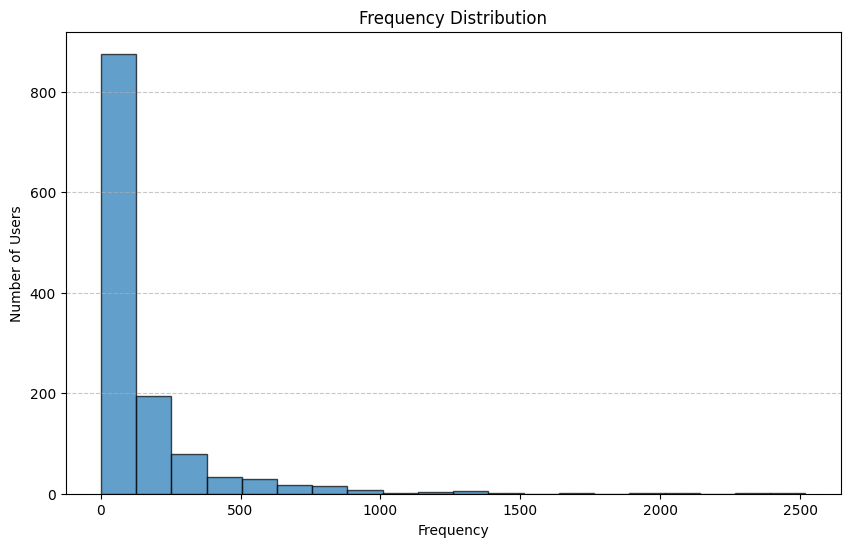

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(rf_mrw_df['Frequency'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def rfm_segment(df):
    if df['Frequency'] > 10 and df['Retention'] < 30:
        return 'Loyal'
    elif df['Frequency'] > 4 and df['Retention'] < 60:
        return 'Potential Loyalist'
    elif df['Frequency'] <= 1:
        return 'New'
    else:
        return 'Churned'

rf_mrw_df['Segment'] = rf_mrw_df.apply(rfm_segment, axis=1)

# Display the segmented data
print(rf_mrw_df['Segment'].value_counts())


Segment
Loyal                 595
Churned               389
Potential Loyalist    210
New                    78
Name: count, dtype: int64


<Axes: >

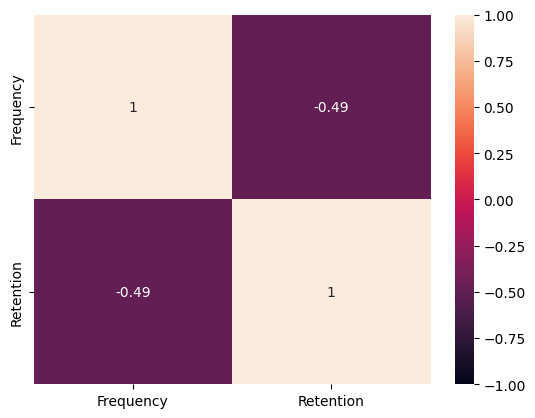

In [ ]:
sns.heatmap(rf_mrw_df[['Frequency','Retention']].corr(method='spearman'), vmin=-1, vmax=1, annot=True)

## จำนวนคนซื้อ/ ปริมาณจำนวน tx ที่ซื้อ

<Axes: xlabel='range'>

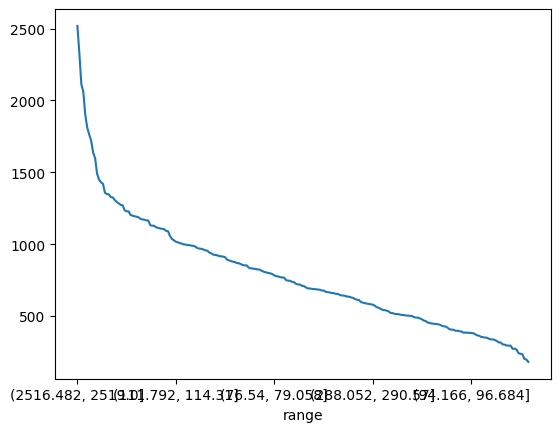

In [ ]:
map_userId_df = pd.cut(mrw_df['UserId'].value_counts(), bins=1000)
map_userId = map_userId_df.to_dict()
mrw_df['range'] = mrw_df['UserId'].apply(lambda x : map_userId[x])
mrw_df['range'].value_counts().plot()

## count scan date plot

In [ ]:
mrw_df['ScanDate'] = pd.to_datetime(mrw_df['ScanDate'])
mrw_df['date'] = mrw_df['ScanDate'].dt.date

count_by_date = mrw_df.groupby('date')['ScanDate'].count()

fig = px.bar(count_by_date, x=count_by_date.index, y='ScanDate',
             title='Count of Transactions by Date')
fig.update_xaxes(title_text='Date', tickformat="%d/%m/%Y")
fig.update_yaxes(title_text='Count')

fig.show()


In [ ]:
mrw_df['ScanDate'] = pd.to_datetime(mrw_df['ScanDate'])
mrw_df['week'] = mrw_df['ScanDate'].dt.isocalendar().week

count_by_date = mrw_df.groupby('week')['ScanDate'].count()

fig = px.bar(count_by_date, x=count_by_date.index, y='ScanDate',
             title='Count of Transactions by Month')
fig.update_xaxes(title_text='Date', tickformat="%d/%m/%Y")
fig.update_yaxes(title_text='Count')

fig.show()

In [ ]:

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
# week_df = df_data.groupby(df_data['arrival_date'].dt.weekday_name).mean().reindex(days)


mrw_transaction_df['ScanDate'] = pd.to_datetime(mrw_transaction_df['ScanDate'])
mrw_transaction_df['weekday'] = mrw_transaction_df['ScanDate'].dt.weekday

count_by_date = mrw_transaction_df.groupby('weekday')['ScanDate'].count()

fig = px.bar(count_by_date, x=count_by_date.index, y='ScanDate',
             title='Count of Transactions by week of the day')

# label x with days list
fig.update_xaxes(ticktext=days)


fig.update_xaxes(title_text='Weekday')
fig.update_yaxes(title_text='Count')

fig.show()


## plot ks

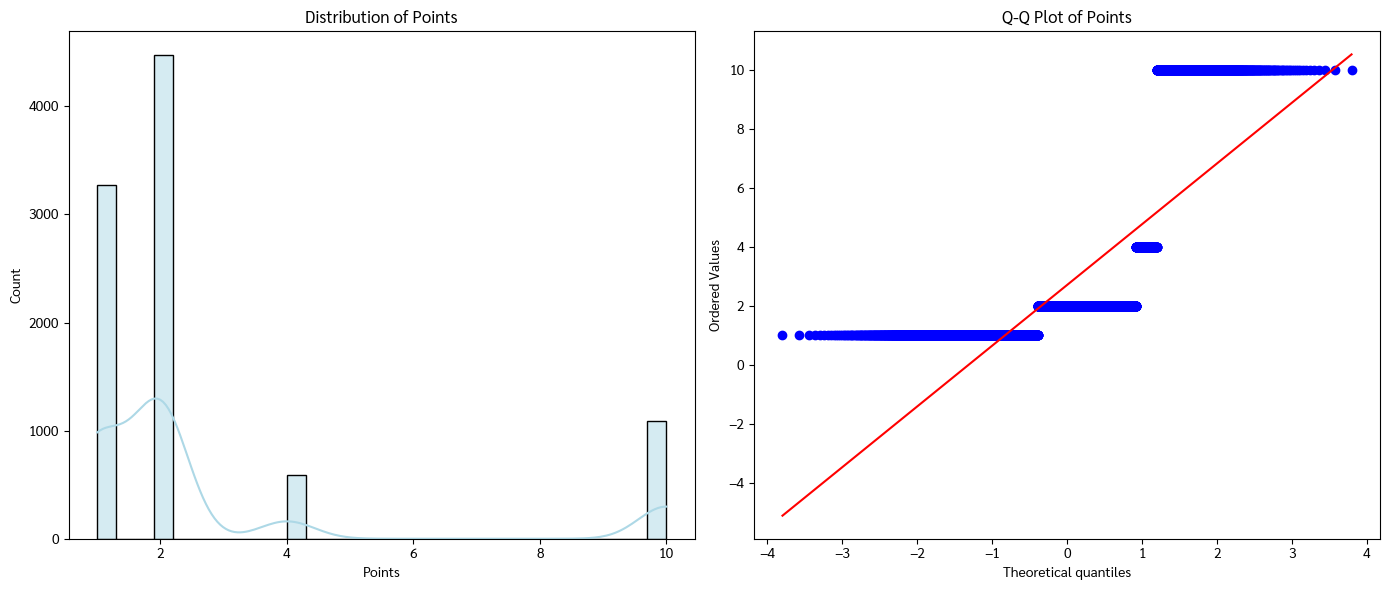

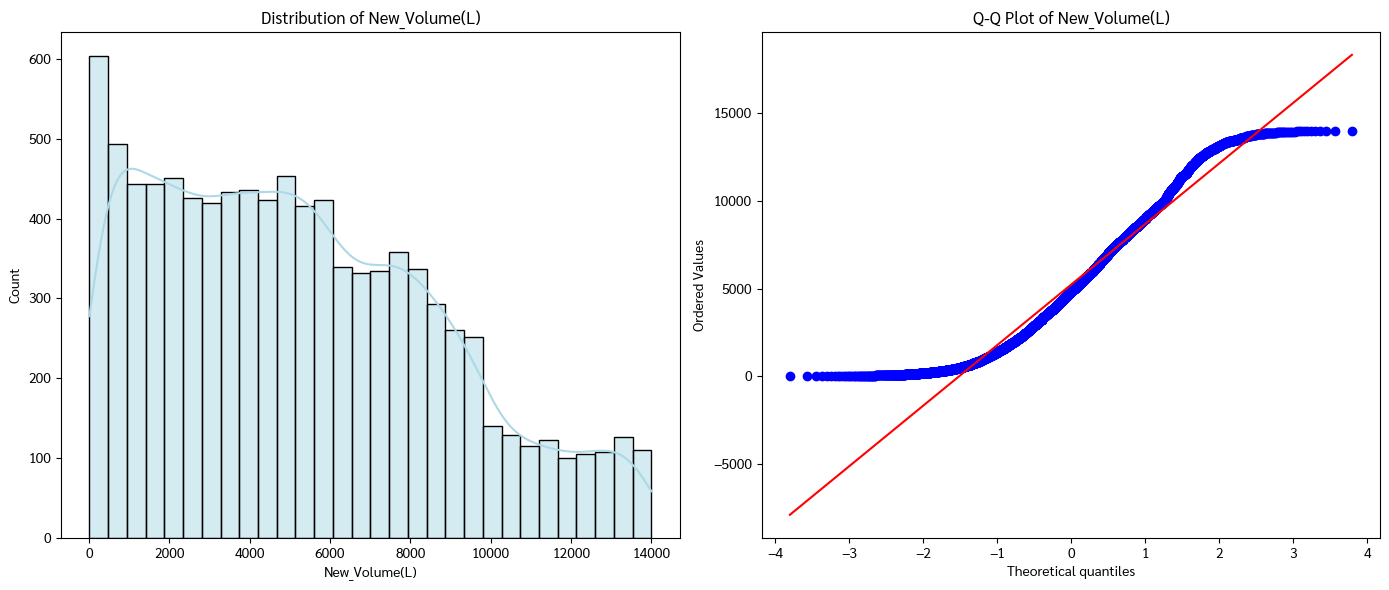

{'Points': (0.42298942076747836, 0.0),
 'New_Volume(L)': (0.0699496863358372, 1.4623149229740374e-40)}

In [ ]:
def plot_distribution_and_qq(column_name, data):
    plt.figure(figsize=(14, 6))

    # Histogram and KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data[column_name], kde=True, color='lightblue', bins=30)
    plt.title(f'Distribution of {column_name}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data[column_name], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column_name}')

    plt.tight_layout()
    plt.show()

columns_to_check = MER_quantitative
for column in columns_to_check:
    plot_distribution_and_qq(column, mer_df)

ks_results = {}

for column in columns_to_check:
    standardized_data = (mer_df[column] - mer_df[column].mean()) / mer_df[column].std()
    stat, p_value = stats.kstest(standardized_data, 'norm')
    ks_results[column] = (stat, p_value)

ks_results

<ipython-input-119-70373d3d3d8f>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




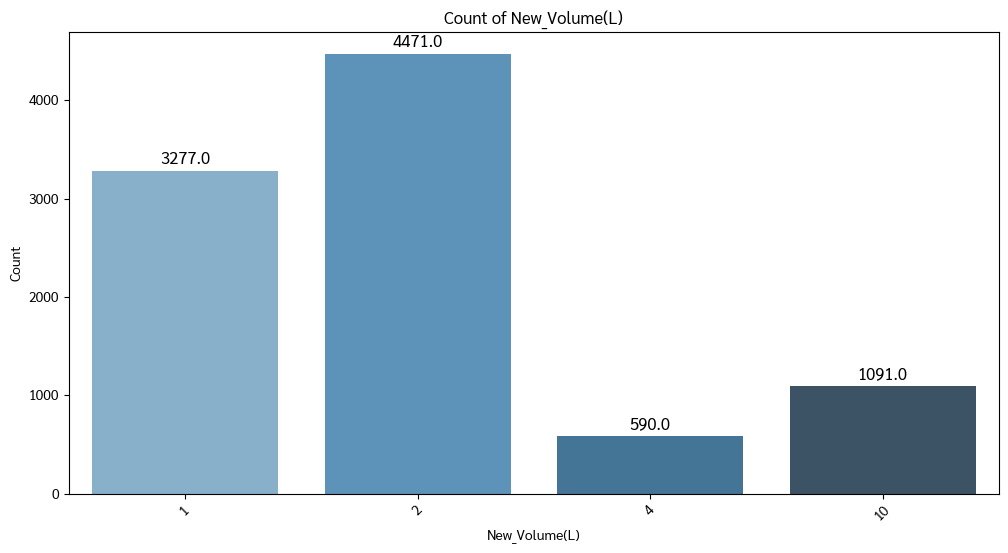

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=mer_df, x=mer_df['Points'], palette='Blues_d')
plt.title(f'Count of {column}')
plt.xlabel(column)
plt.ylabel('Count')
# Add count labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45)
plt.show()

## rf analysis v2 + clustering

In [ ]:
user_volumn_point = mrw_df.groupby('OwnerId')[['Points','Volume (L)']].sum().reset_index()
user_volumn_point = user_volumn_point.rename(columns={'Points': 'TotalPoints', 'Volume (L)': 'TotalVolume(L)'})
user_volumn_point.head(5)

print(user_volumn_point.shape)

(1272, 3)


In [ ]:
user_distributor = mrw_df.groupby('OwnerId')['Distributor_x'].agg(pd.Series.mode).to_frame()
print(user_distributor.shape)
# user_distributor.tail()

(1272, 1)


In [ ]:
rf_data = pd.read_csv("rf_data.csv")
rf_data = pd.merge(rf_data, user_volumn_point, on='OwnerId')
rf_data.head()

Unnamed: 0            OwnerId  Frequency  Retention  FrequencyBin  \
0           0  EXL_1569867483497          7         29             1   
1           1  EXL_1569928027697        189          5             4   
2           2  EXL_1569941239614        141         34             4   
3           3  EXL_1569942582305          1        360             1   
4           4  EXL_1570017799372        329         48             5   

   RetentionBin  TotalPoints  TotalVolume(L)  
0             3          370              42  
1             1         6605            1129  
2             3         5620             796  
3             5           35               6  
4             4        12860            1852

In [ ]:
rf_data = pd.merge(rf_data, user_distributor, on='OwnerId')
rf_data.head()

Unnamed: 0            OwnerId  Frequency  Retention  FrequencyBin  \
0           0  EXL_1569867483497          7         29             1   
1           1  EXL_1569928027697        189          5             4   
2           2  EXL_1569941239614        141         34             4   
3           3  EXL_1569942582305          1        360             1   
4           4  EXL_1570017799372        329         48             5   

   RetentionBin  TotalPoints  TotalVolume(L) Distributor_x  
0             3          370              42             B  
1             1         6605            1129             B  
2             3         5620             796             A  
3             5           35               6             C  
4             4        12860            1852             D

In [ ]:
customer_behavior = rf_data[['OwnerId', 'Frequency', 'Retention','TotalPoints', 'TotalVolume(L)', 'Distributor_x']]
customer_behavior.shape  #(1272, 7)
customer_behavior.head()

OwnerId  Frequency  Retention  TotalPoints  TotalVolume(L)  \
0  EXL_1569867483497          7         29          370              42   
1  EXL_1569928027697        189          5         6605            1129   
2  EXL_1569941239614        141         34         5620             796   
3  EXL_1569942582305          1        360           35               6   
4  EXL_1570017799372        329         48        12860            1852   

  Distributor_x  
0             B  
1             B  
2             A  
3             C  
4             D

In [ ]:
selected_features = ['Frequency', 'Retention','TotalPoints', 'TotalVolume(L)']  #, 'Distributor_x'
data_for_cluster = customer_behavior[selected_features]
eval_data_to_concat_cluster = data_for_cluster.copy()
eval_data_to_concat_cluster.head()

Frequency  Retention  TotalPoints  TotalVolume(L)
0          7         29          370              42
1        189          5         6605            1129
2        141         34         5620             796
3          1        360           35               6
4        329         48        12860            1852

In [ ]:
scale_data_for_cluster = (data_for_cluster-data_for_cluster.mean())/data_for_cluster.std()
scale_data_for_cluster.head()

Frequency  Retention  TotalPoints  TotalVolume(L)
0  -0.548096  -0.484323    -0.497908       -0.561771
1   0.193461  -0.740685     0.179586        0.199098
2  -0.002114  -0.430914     0.072556       -0.033992
3  -0.572543   3.051334    -0.534309       -0.586970
4   0.763890  -0.281370     0.859253        0.705178

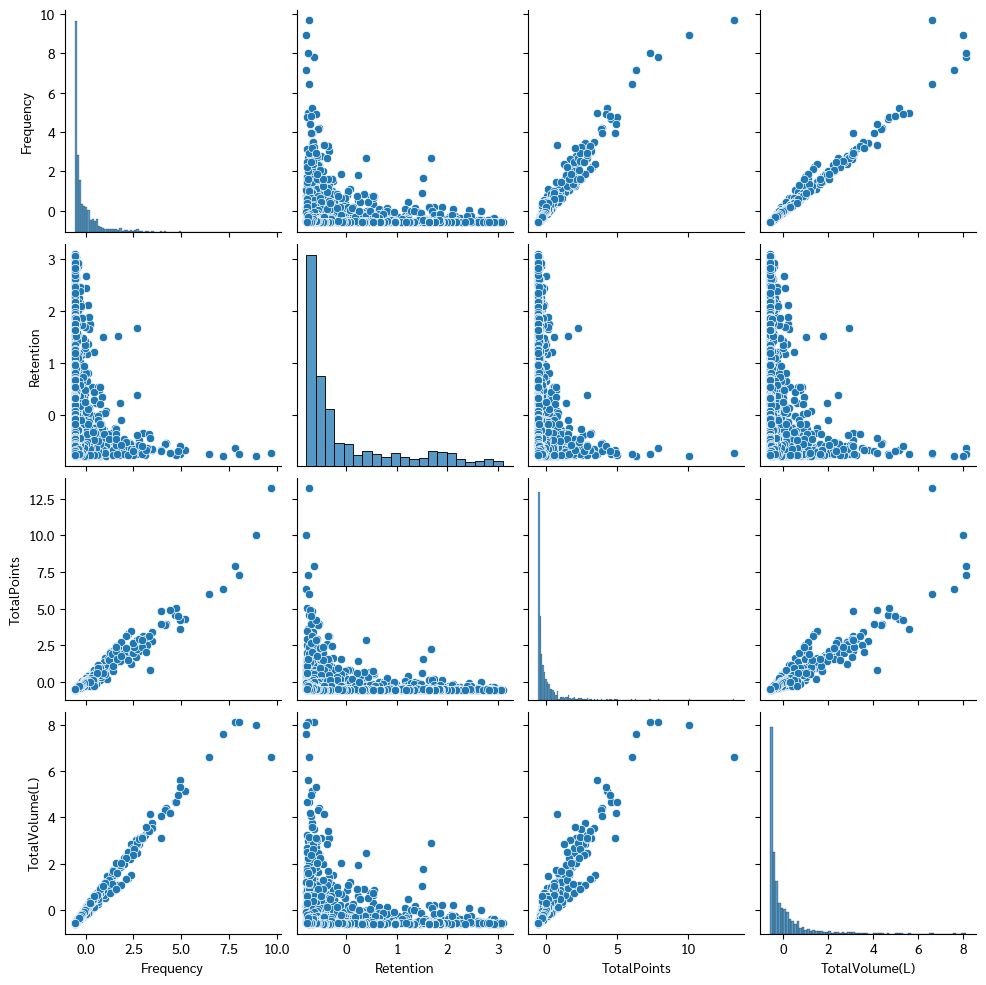

In [ ]:
sns.pairplot(scale_data_for_cluster)

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

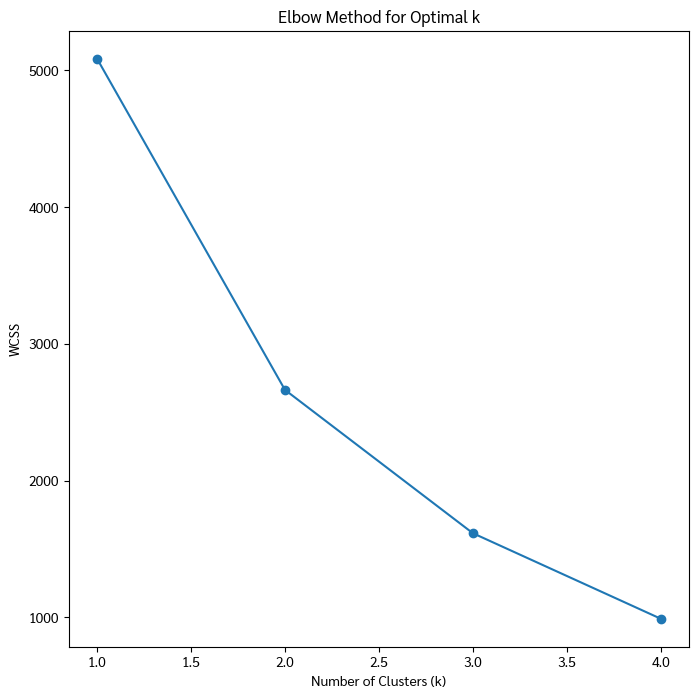

In [ ]:
from sklearn.cluster import KMeans

x = scale_data_for_cluster[selected_features].values
inertia = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, n_init=6 ,random_state=0)
    kmeans.fit(scale_data_for_cluster)
    inertia.append(kmeans.inertia_)
    plt.figure(figsize=(8, 8))
plt.plot(range(1, 5), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette score for 2 Cluster: 0.6854


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette score for 3 Cluster: 0.5744


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette score for 4 Cluster: 0.5891


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette score for 5 Cluster: 0.5330


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette score for 6 Cluster: 0.5247


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette score for 7 Cluster: 0.5095


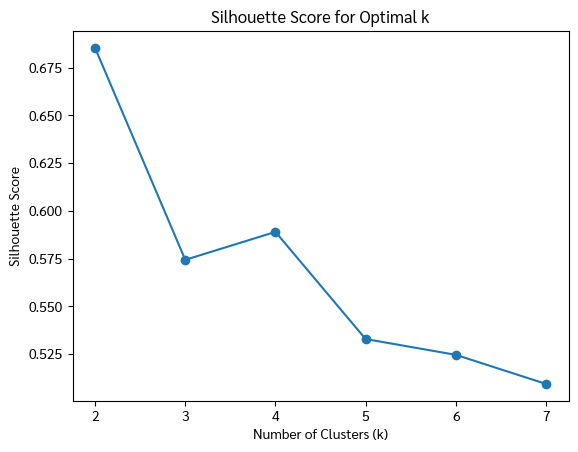

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
krange = list(range(2,8))

for k in krange:
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(scale_data_for_cluster)
    silhouette_avg = silhouette_score(scale_data_for_cluster, clusters)
    silhouette_scores.append(silhouette_avg)
    print('silhouette score for %i Cluster: %0.4f' % (k, silhouette_avg))


plt.plot(krange, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


In [ ]:
cluster2 = cluster.KMeans(n_clusters= 2, random_state = 15)
cluster2.fit(scale_data_for_cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=2, random_state=15)

In [ ]:
cluster2.cluster_centers_
cluster = cluster2.labels_ + 1 # change from cluster name 0-1 to 1-2
cluster

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
scale_data_for_cluster["cluster"] = cluster
scale_data_for_cluster.head()

Frequency  Retention  TotalPoints  TotalVolume(L)  cluster
0  -0.548096  -0.484323    -0.497908       -0.561771        1
1   0.193461  -0.740685     0.179586        0.199098        1
2  -0.002114  -0.430914     0.072556       -0.033992        1
3  -0.572543   3.051334    -0.534309       -0.586970        1
4   0.763890  -0.281370     0.859253        0.705178        1

In [ ]:
scale_data_for_cluster.groupby("cluster").mean()

Frequency  Retention  TotalPoints  TotalVolume(L)
cluster                                                   
1        -0.243858   0.056515    -0.237116       -0.243833
2         2.601897  -0.602998     2.529962        2.601632

In [ ]:
eval_data_to_concat_cluster["cluster"] = cluster
eval_data_to_concat_cluster.groupby('cluster').mean()

Frequency  Retention   TotalPoints  TotalVolume(L)
cluster                                                     
1         81.668960  79.631986   2770.081685      496.214961
2        780.100917  17.889908  28235.596330     4561.330275

In [ ]:
eval_data_to_concat_cluster["cluster"] = cluster

eval_data_to_concat_cluster.groupby('cluster').median()

Frequency  Retention  TotalPoints  TotalVolume(L)
cluster                                                   
1             43.0       34.0       1360.0           263.0
2            654.0        9.0      23490.0          3821.0

In [ ]:
scale_data_for_cluster.groupby('cluster').size().reset_index(name='count')

cluster  count
0        1   1163
1        2    109

### 🚩 Cluster Character
 Cluster 2 เป็นกลุ่มที่มี Frequency เยอะ แล้วก็ Retention น้อย แปลว่าซื้อบ่อย ซึ่งมีไม่เยอะ   

แต่ยังมีลูกค้า cluster 1 ที่ยังมีจำนวนซื้อน้อย ถ้าเราสามารถทำให้ cluster 1 ซื้อเยอะขึ้น บ่อยขึ้นได้ น่าจะ grow sale ได้เยอะกว่านี้ ส่วน cluster 2 มี Royalty program มาช่วยให้เค้าอยู่กับเราไปนานๆ

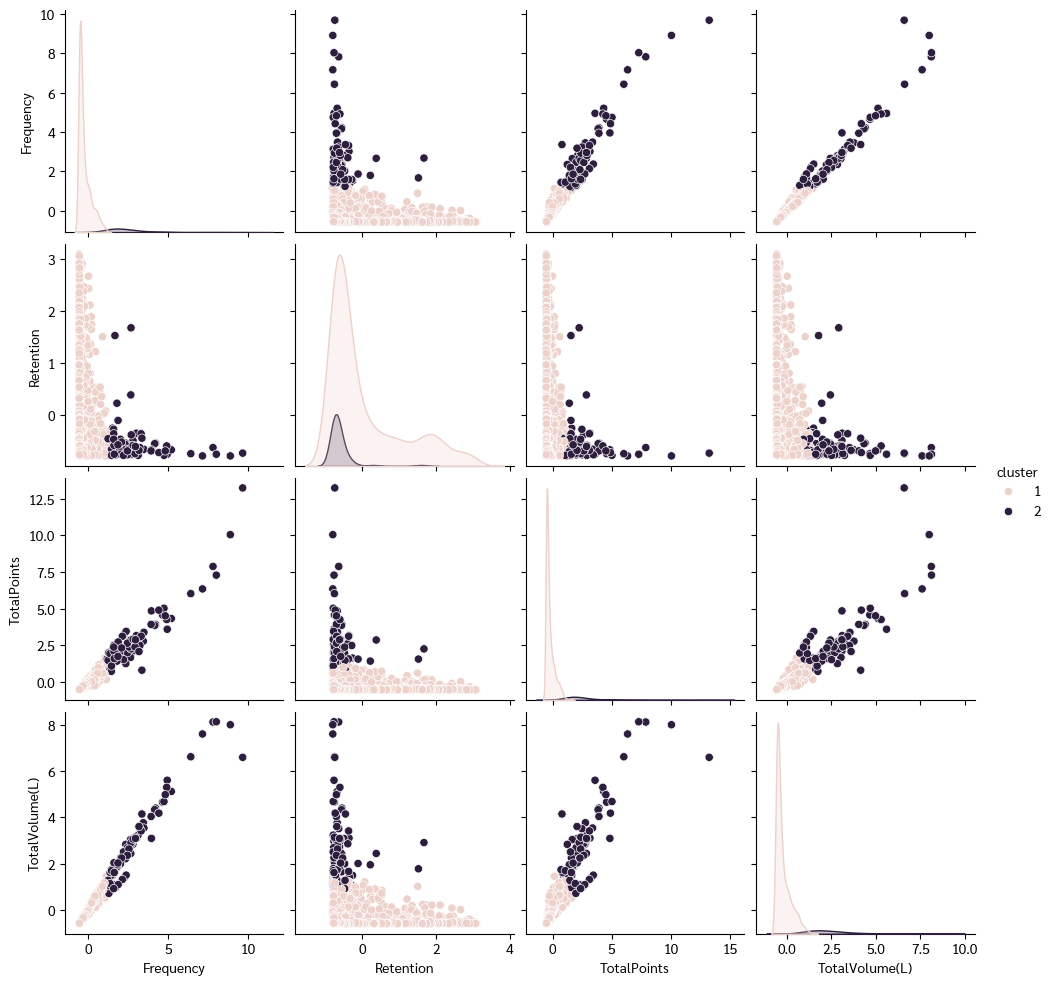

In [ ]:
sns.pairplot(scale_data_for_cluster, hue='cluster')

### predict churn (not used)

In [ ]:
#train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
churn_threshold = 1  # Example threshold for churn
rf_data['Churn'] = (rf_data['Retention'] < churn_threshold).astype(int)

In [ ]:
features = ['Frequency', 'Retention']
target = 'Churn'
X = rf_data[features]
y = rf_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:", report)

Accuracy: 1.0
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00         6

    accuracy                           1.00       255
   macro avg       1.00      1.00      1.00       255
weighted avg       1.00      1.00      1.00       255

